### Recommendation System

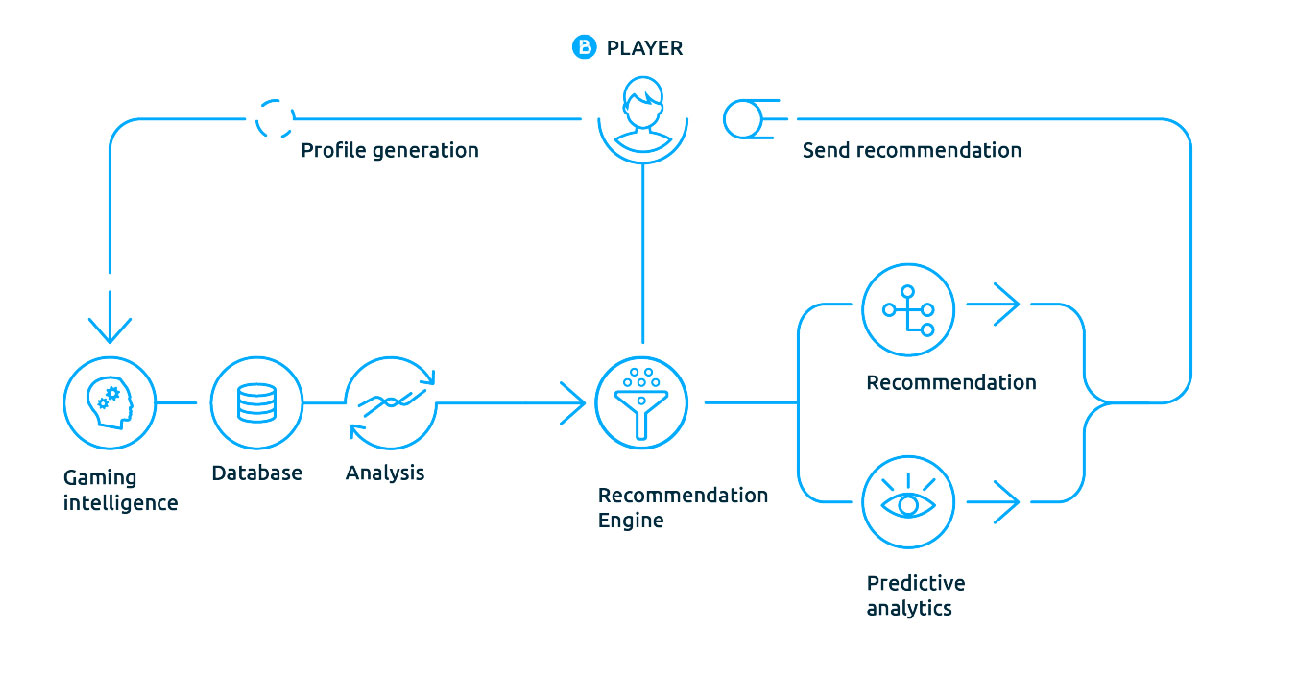

## Dataset Information

Million Songs Dataset contains of two files: 
 triplet_file and metadata_file. 

1. The triplet_file contains **User_Id, Song_Id and Listen Counts**. 

2. The metadata_file contains **Track_Id, Song_Id, Artist_Name, Title**.

Million Songs Dataset is a mixture of song from various website with the rating that users gave after listening to the song.

There are 3 types of recommendation system: content-based, collaborative and popularity.

### Importing Liberaries 

In [1]:
import pandas as pd

In [2]:
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
def ignore_warn(*args, **kwargs):
    pass

warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

import numpy as np
import time
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.sparse import coo_matrix
import math as mt
from scipy.sparse.linalg import * #used for matrix multiplication
from scipy.sparse.linalg import svds
from scipy.sparse import csc_matrix
from scipy.stats import skew, norm, probplot
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
color = sns.color_palette()
sns.set_style('darkgrid')

In [3]:
from collections import defaultdict
usersDict = defaultdict(int)
with open("kaggle_visible_evaluation_triplets.txt", "r") as songFile:
    for record in songFile:
        #Fetch user id as the first item from a tab delimited line of record
        user = record.split("\t")[0]
        #Fetch song play count as the last item from a tab delimited line of record
        play_count = int(record.split("\t")[2])
        #Update song play count for a user
        usersDict[user] += play_count
        
userPlayCountList = [{'user': u, 'play_count': p} for u,p in usersDict.items()]
dfSongsPlayCount = pd.DataFrame(userPlayCountList)
#Arrange the user songs played records in descending order to facilitate further analysis
dfSongsPlayCount = dfSongsPlayCount.sort_values(by = 'play_count', ascending = False)
dfSongsPlayCount.to_csv("Final_songs_play_count.csv", index=None)

In [4]:
dfSongsPlayCount.shape

(110000, 2)

In [5]:
dfSongsPlayCount.head()

,user,play_count
93249,090b841eaf56d343a26625c2c6d08b823927bc4f,1305
42095,938c2632d43eeadb8a83a7cc254d014f9cea6afe,1267
106017,1c5aa998482a40abfd020759e7d757eb6c510e72,1200
1849,c6150292374fb1dad89982367b3245dd5004c718,1192
58514,5a9375e46a7e9b869058c7bc0e820e00d77f3e0b,1184


In [6]:
totalPlayCount = sum(dfSongsPlayCount.play_count)
(float(dfSongsPlayCount.head(n=100000).play_count.sum())/totalPlayCount)*100
dfUserSubset = dfSongsPlayCount.head(n=100000)

In [7]:
dfUserSubset=dfSongsPlayCount.copy()

In [8]:
songsDict = defaultdict(int)
with open("kaggle_visible_evaluation_triplets.txt", "r") as songFile:
    for record in songFile:
        #Fetch song id as the first item from a tab delimited line of record
        song = record.split("\t")[1]
        #Fetch song play count as the last item from a tab delimited line of record
        play_count = int(record.split("\t")[2])
        #Update song play count for a song
        songsDict[song] += play_count
        
songPlayCountList = [{'song': s, 'play_count': p} for s,p in songsDict.items()]
dfSongsPlaySummary = pd.DataFrame(songPlayCountList)
#Arrange the user songs played records in descending order to facilitate further analysis
dfSongsPlaySummary = dfSongsPlaySummary.sort_values(by = 'play_count', ascending = False)
dfSongsPlaySummary.to_csv("songs_summary.csv", index=None)

In [9]:
dfSongsPlaySummary.shape

(163206, 2)

In [10]:
dfSongPlayCountSubset=dfSongsPlaySummary.copy()

In [11]:
dfAllSongs = pd.read_csv("kaggle_visible_evaluation_triplets.txt", sep="\t", names=['user', 'song', 'play_count'], header=None)
#Filter records for top 40% users using the users subset found earlier
dfSongsTopUsers = dfAllSongs[dfAllSongs.user.isin(list(dfUserSubset.user))]
dfSongsTopSongs = dfSongsTopUsers[dfSongsTopUsers.song.isin(list(dfSongPlayCountSubset.song))]

In [12]:
dfSongsTopUsers.shape

(1450933, 3)

In [13]:
dfSongsTopSongs.shape

(1450933, 3)

In [14]:
#Save the top 30 songs dataset to a file
dfSongsTopSongs.to_csv("triplet.csv", index=False)
#Find the number of records in this subset
dfSongsTopSongs.shape

(1450933, 3)

In [15]:
triplet = pd.read_csv("triplet.csv")

In [16]:
triplet.shape

(1450933, 3)

In [17]:
unique= pd.read_csv("unique_tracks.txt",sep = "<SEP>", names = ["track","song","artist_name","title"])
unique_track = unique[unique.song.isin(list(dfSongPlayCountSubset.song))]

In [18]:
unique_track.shape

(163828, 4)

### Merging Data

In [19]:
unique_track.drop_duplicates(['song'], inplace=True)
#Join the earlier obtained top popular songs dataset and this metadata dataframe on song id
song_data = pd.merge(triplet, unique_track, how="left", 
                                      left_on="song", right_on = "song")
#Keep only relevant columns
song_data = song_data[['track','user', 'song','play_count', 'artist_name','title']]
song_data.head(3)

,track,user,song,play_count,artist_name,title
0,TRAEHHJ12903CF492F,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOBONKR12A58A7A7E0,1,Dwight Yoakam,You're The One
1,TRLGMFJ128F4217DBE,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOEGIYH12A6D4FC0E3,1,Barry Tuckwell/Academy of St Martin-in-the-Fie...,Horn Concerto No. 4 in E flat K495: II. Romanc...
2,TRTNDNE128F1486812,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOFLJQZ12A6D4FADA6,1,Cartola,Tive Sim


In [20]:
print(song_data.shape[0],"Rows","&",song_data .shape[1],"Columns" )

1450933 Rows & 6 Columns


## Explorartory Data Analyses

In [21]:
print("Rows, Column of unique_track data after seperation is :" ,unique_track.shape)
print("Rows, Column of triplet data after seperation is :" ,triplet.shape)

Rows, Column of unique_track data after seperation is : (163206, 4)
Rows, Column of triplet data after seperation is : (1450933, 3)


### This dataset is really large, let's see unique values in features

In [22]:
print("Unique Song ID's in song_data are:", len(song_data["song"].unique()))
print("Unique Artist Names in song_data are:", len(song_data["artist_name"].unique()))
print("Unique Titles in unique song_data are:", len(song_data["title"].unique()))

Unique Song ID's in song_data are: 163206
Unique Artist Names in song_data are: 28361
Unique Titles in unique song_data are: 137627


In [23]:
print("Unique users in song_data are:", len(song_data["user"].unique()))
print("Unique songs in song_data are:", len(song_data["song"].unique()))
print("Unique play_counts in song_data are:", len(song_data["play_count"].unique()))

Unique users in song_data are: 110000
Unique songs in song_data are: 163206
Unique play_counts in song_data are: 299


### Let's see Kernel Density Estimate which is used for visualizing the Probability Density 

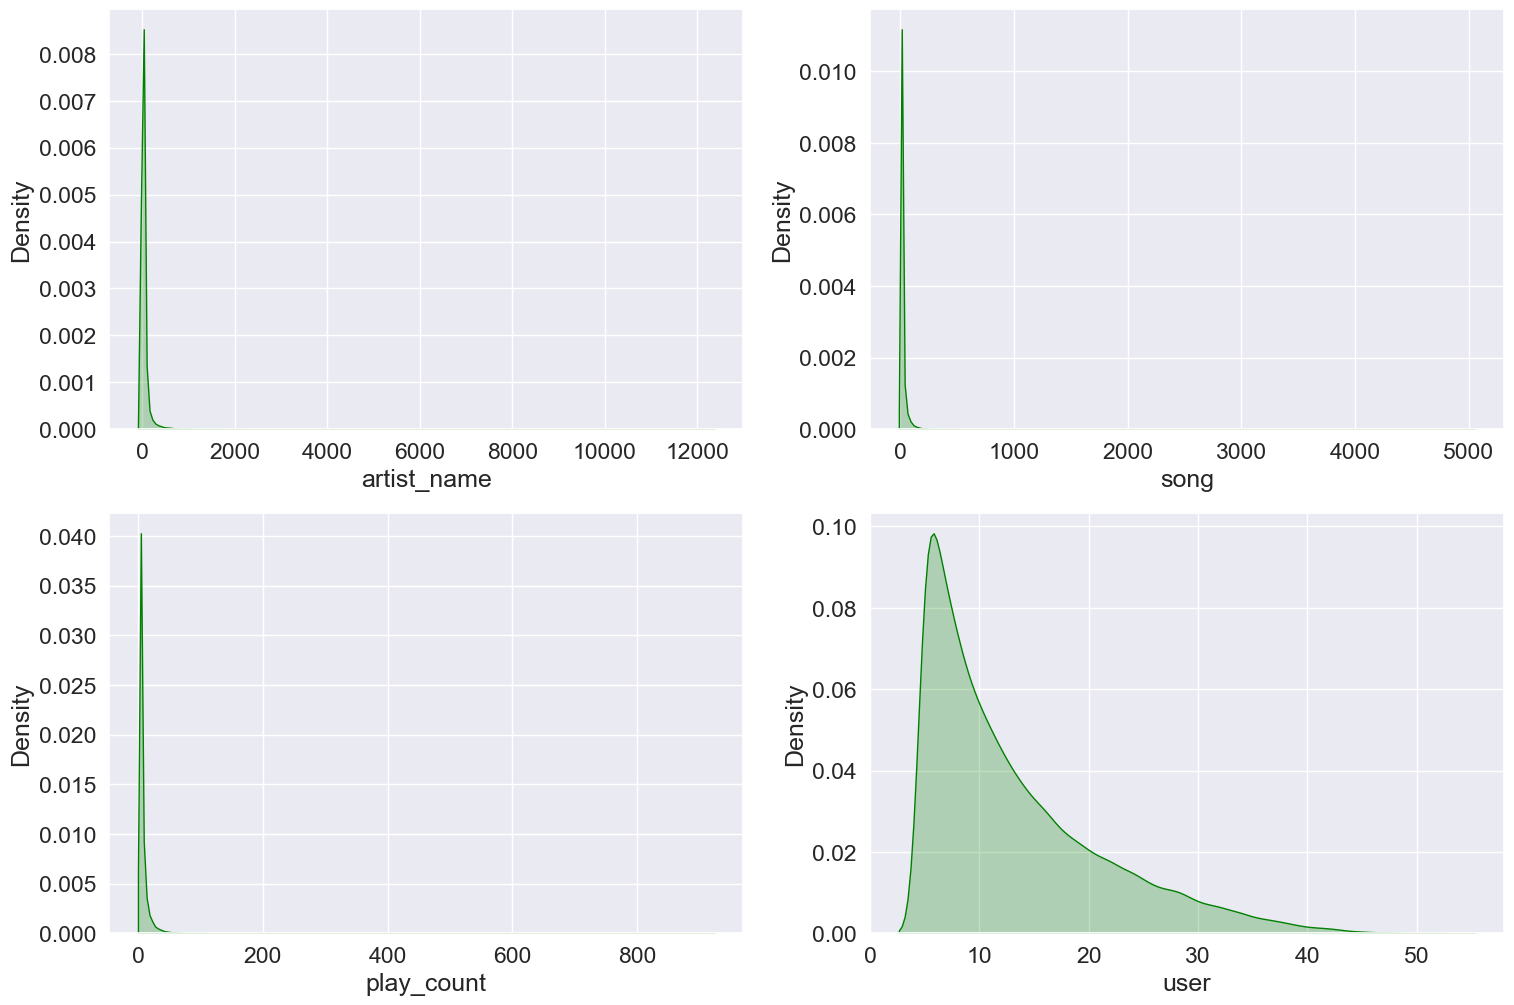

In [24]:
fig = plt.figure(figsize=(18, 12))

a1 = fig.add_subplot(221)
f1=sns.kdeplot(data=song_data,shade = True, color = 'green', x=song_data["artist_name"].value_counts())

a2 = fig.add_subplot(222)
f1=sns.kdeplot(data=song_data,shade = True, color = 'green', x=song_data["song"].value_counts())

a3 = fig.add_subplot(223)
f1=sns.kdeplot(data=song_data, shade = True, color = 'green', x=song_data["play_count"])

a4 = fig.add_subplot(224)
f1=sns.kdeplot(data=song_data,shade = True, color = 'green',  x=song_data["user"].value_counts())



### Lets describe the data

In [25]:
song_data.describe().T

,count,mean,std,min,25%,50%,75%,max
play_count,1450933.0,3.187149,7.051664,1.0,1.0,1.0,3.0,923.0


In [26]:
song_data.describe(include = "O").T

,count,unique,top,freq
track,1450933,163206,TRDMBIJ128F4290431,5043
user,1450933,110000,7d90be8dfdbde170f036ce8a4b915440137cb11c,53
song,1450933,163206,SOFRQTD12A81C233C0,5043
artist_name,1450933,28361,Coldplay,12279
title,1450932,137626,Sehr kosmisch,5043


#### Check missing values

In [27]:
print("Total Number of Null Value in data:", song_data.isnull().sum().sum())

Total Number of Null Value in data: 1


In [28]:
song_data.isnull().sum()

track          0
user           0
song           0
play_count     0
artist_name    0
title          1
dtype: int64

In [29]:
 song_data["title"]=song_data["title"].fillna(song_data["title"].mode()[0])

In [30]:
print('{:d} users, {:.2%} of total play counts, listening a single more than 200 times'.format(
    song_data.user[song_data.play_count>200].unique().shape[0],
    song_data.play_count[song_data.play_count>200].count()/song_data.shape[0]))
display(song_data.play_count[song_data.play_count>200].describe().reset_index().T)

138 users, 0.01% of total play counts, listening a single more than 200 times


,0,1,2,3,4,5,6,7
index,count,mean,std,min,25%,50%,75%,max
play_count,154,286.188,102.503,201,221,250,310.25,923


So, as we can see only 138 users listen to a single song more than 200 times, but, would this be possible?

In [31]:
song_grouped = song_data.groupby(['song',]).agg({'play_count':'count'}).sort_values('play_count', ascending=False).reset_index()
song_grouped.head(10) 

,song,play_count
0,SOFRQTD12A81C233C0,5043
1,SOAUWYT12A81C206F1,4483
2,SOBONKR12A58A7A7E0,4136
3,SOAXGDH12A8C13F8A1,3780
4,SOSXLTC12AF72A7F54,3672
5,SONYKOW12AB01849C9,3430
6,SOEGIYH12A6D4FC0E3,3272
7,SODJWHY12A8C142CCE,2791
8,SOLFXKT12AB017E3E0,2725
9,SOFLJQZ12A6D4FADA6,2668


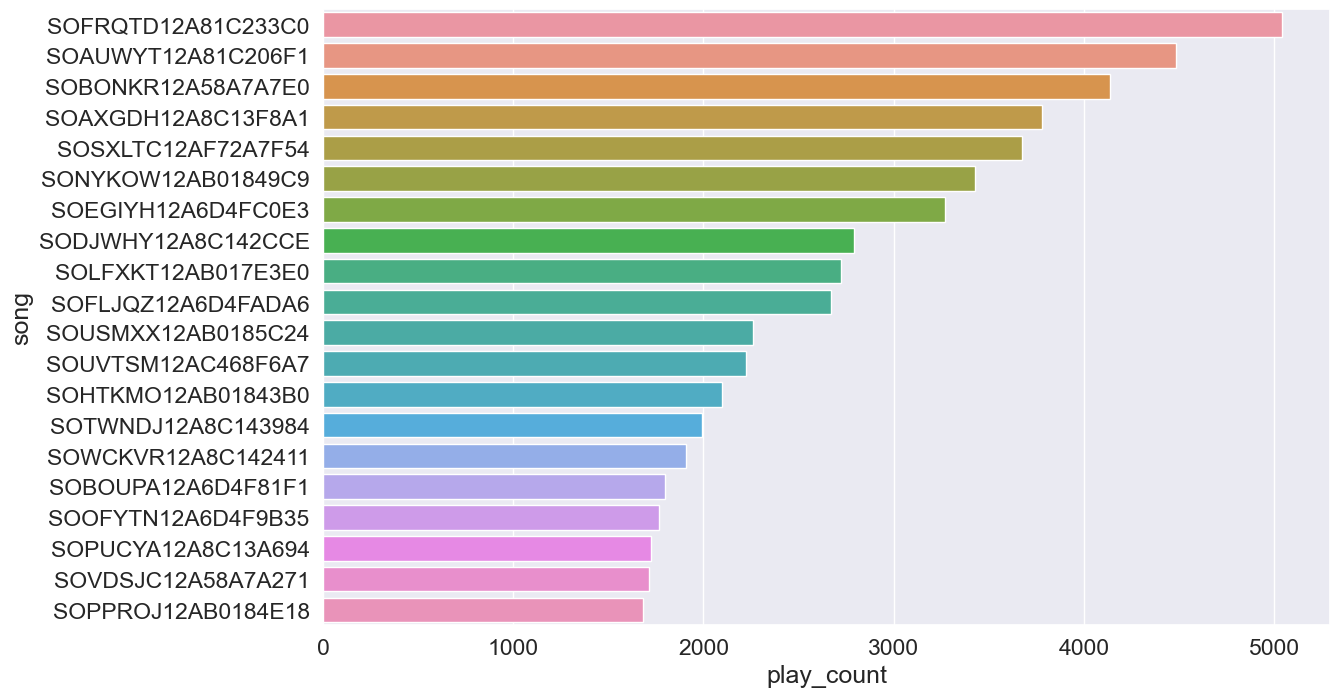

In [32]:
plt.figure(figsize = (13,8))
sns.barplot(y=song_grouped['song'][:20], x=song_grouped["play_count"])
plt.show()

## Analysis of Users

In [33]:
song_per_user = song_data.groupby(['user',]).agg({'play_count':'count'}).sort_values('play_count', ascending=False).reset_index() 

In [34]:
song_per_user

,user,play_count
0,7d90be8dfdbde170f036ce8a4b915440137cb11c,53
1,d30e18323f15426c3cdc8585252ed34459916f51,52
2,03ad93fdb01506ce205f4708decf8e4b1ae90fff,52
3,2e424b28bff1f62a2dae22a918f09f9c30c06d1b,52
4,016a24e91a72c159a5048ab1b9b2ba5ce761b526,52
...,...,...
109995,dc14d67f7d79c2e54c5a220ceca3fea2baf8e0d3,5
109996,dc152fb9b0b72648dc10e6ed6effb3b148aa316a,5
109997,dc1b5222568cc291fe6bed8d6b37ce780ac661e5,5
109998,66bdee78bbcd7e82d359173ef801f5094b40a344,5


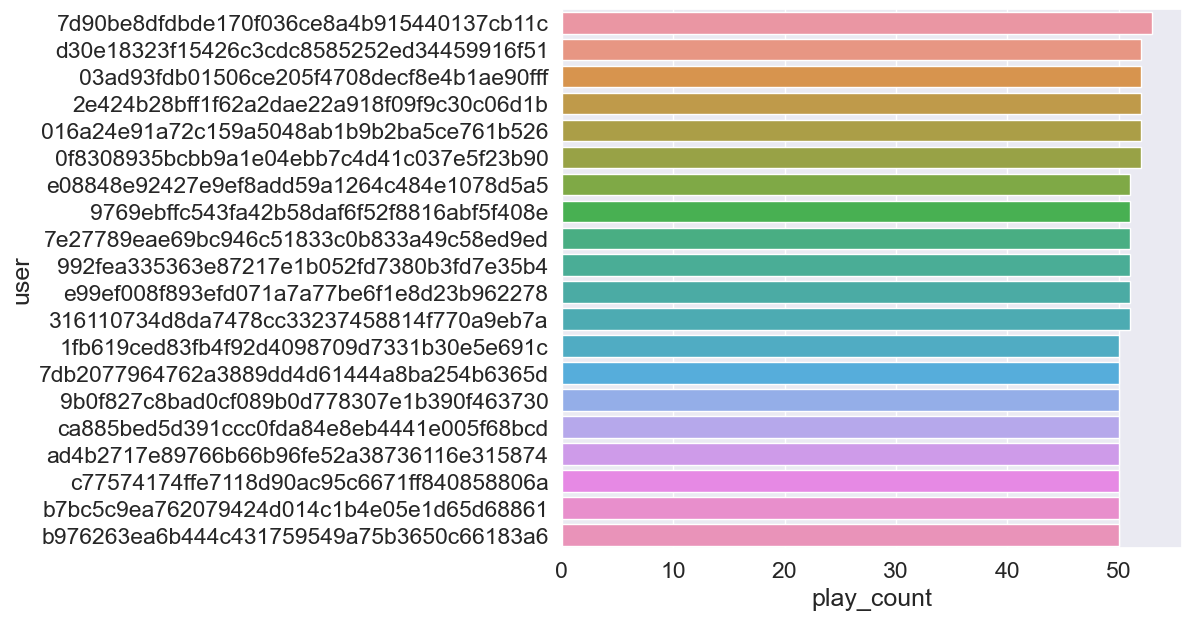

In [35]:
plt.figure(figsize = (8,7))
sns.barplot(y=song_per_user['user'][:20], x=song_per_user["play_count"])
plt.show()

## Analysis of Artist

In [36]:
popular_artist = song_data.groupby(['artist_name',]).agg({'play_count':'count'}).sort_values('play_count', ascending=False)
popular_artist.head(10)

,play_count
artist_name,
Coldplay,12279
Kings Of Leon,8514
Florence + The Machine,8213
Justin Bieber,7669
Jack Johnson,6784
Train,6617
The Black Keys,6507
Eminem,6297
OneRepublic,6027


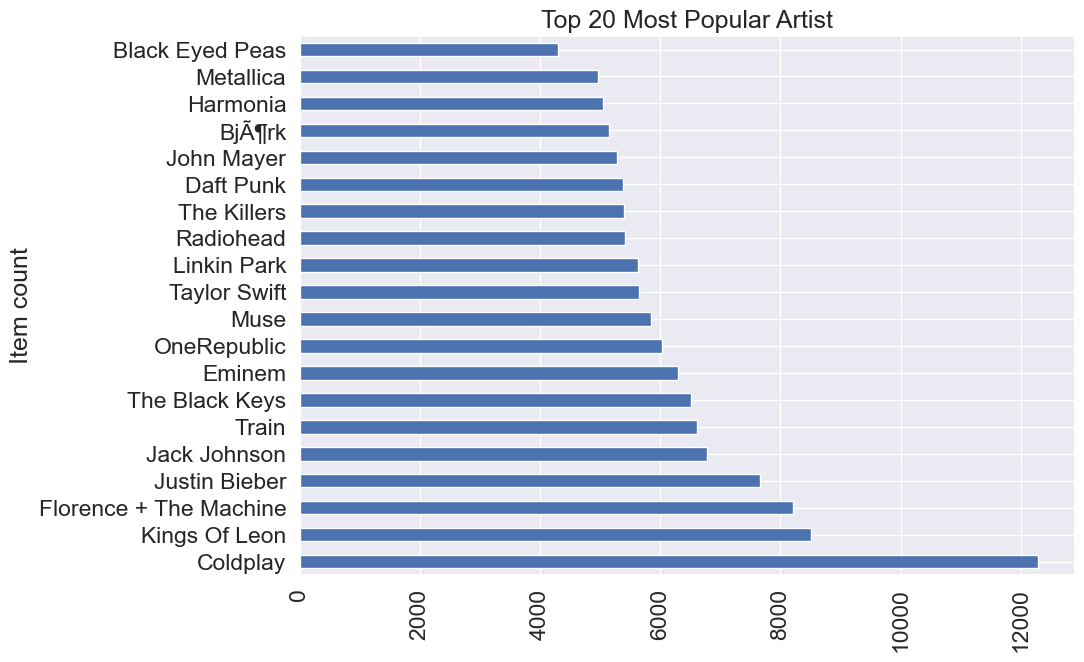

In [37]:
plt.rcParams["figure.figsize"] = (10,7)

popular_artist[:20].plot(kind='barh', title='Top 20 Most Popular Artist', legend=False,)
plt.xticks(rotation='vertical')
plt.ylabel('Item count')

plt.show()

## Analysis of songs

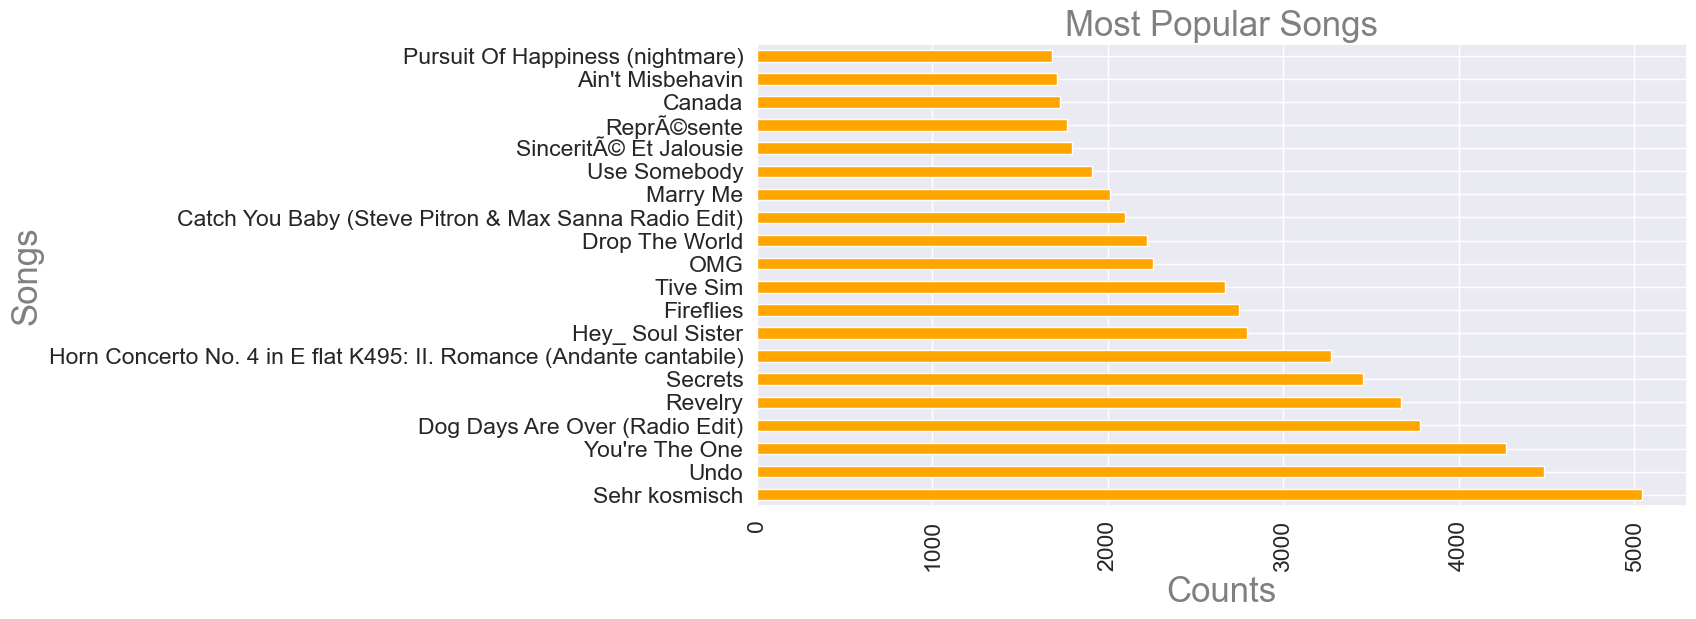

In [38]:
plt.figure(figsize = (12,6))
#song_data['title'].value_counts().head(20).plot.bar(kind='barh',color = 'orange')
song_data['title'].value_counts().head(20).plot(color = 'orange',kind='barh', title='Top 20 Most Popular Artist', legend=False,)
plt.title('Most Popular Songs',color = 'Grey',fontsize=25)
plt.xticks(rotation='vertical')
plt.xlabel('Counts',color = 'Grey',fontsize=25)
plt.ylabel('Songs',color = 'Grey',fontsize=25)
plt.show()

In [39]:
song_data['title'].value_counts().head(5)

Sehr kosmisch                     5044
Undo                              4483
You're The One                    4270
Dog Days Are Over (Radio Edit)    3780
Revelry                           3672
Name: title, dtype: int64

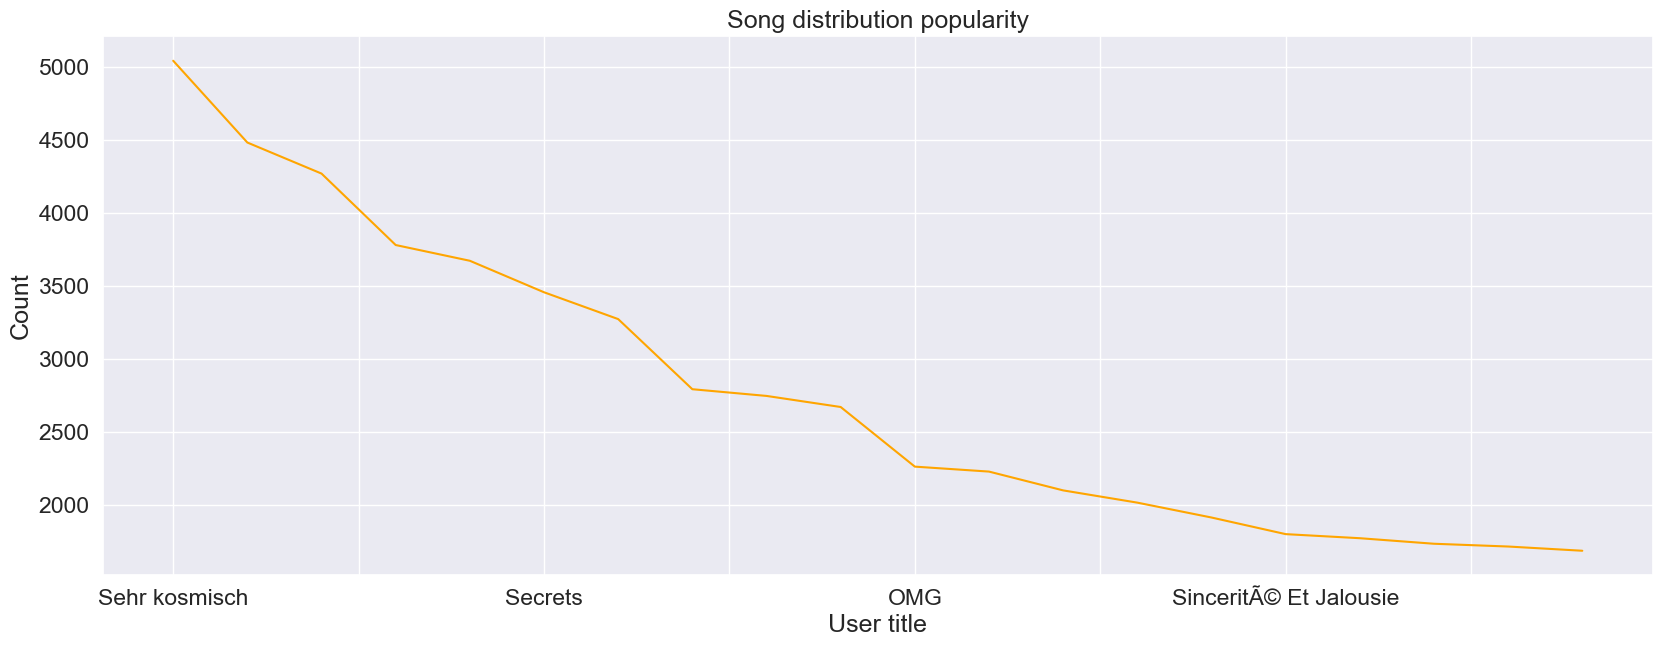

In [40]:
plt.figure(figsize = (20,7))
song_data['title'].value_counts().head(20).plot.line(color = 'orange')
plt.title('Song distribution popularity')
plt.xlabel('User title')
plt.ylabel('Count')
plt.show()

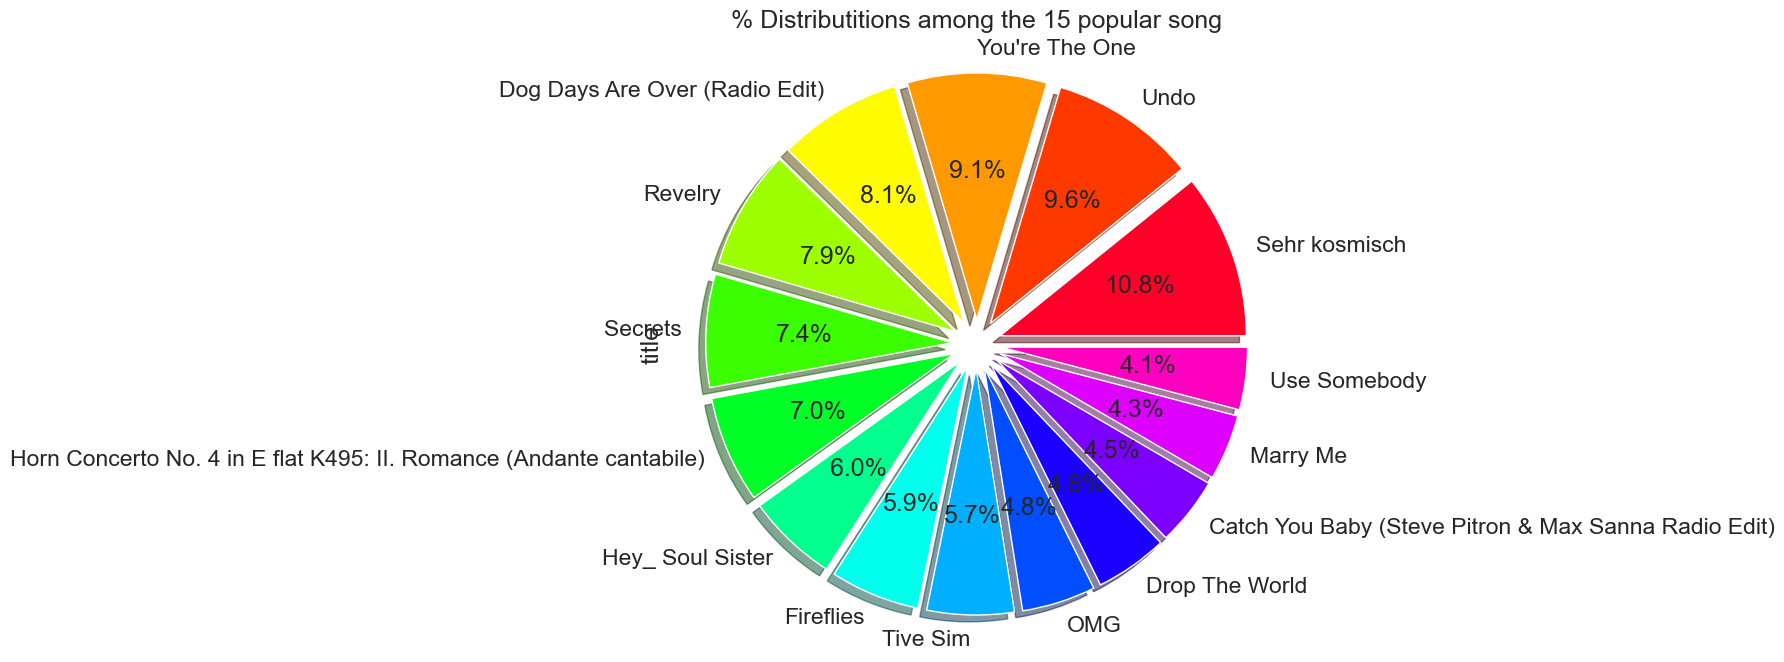

In [41]:
#plt.style.use('dark_background') 
plt.figure(figsize = (20,8))
song_data['title'].value_counts()[:15].plot.pie(explode=[0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1],autopct='%1.1f%%',shadow=True,cmap='gist_rainbow')
plt.title('% Distributitions among the 15 popular song')
plt.show()

#### So we have to be careful when creating a recommendation system that can be affected by the outliers. Let's take a look at the top 20 in the different features we have:

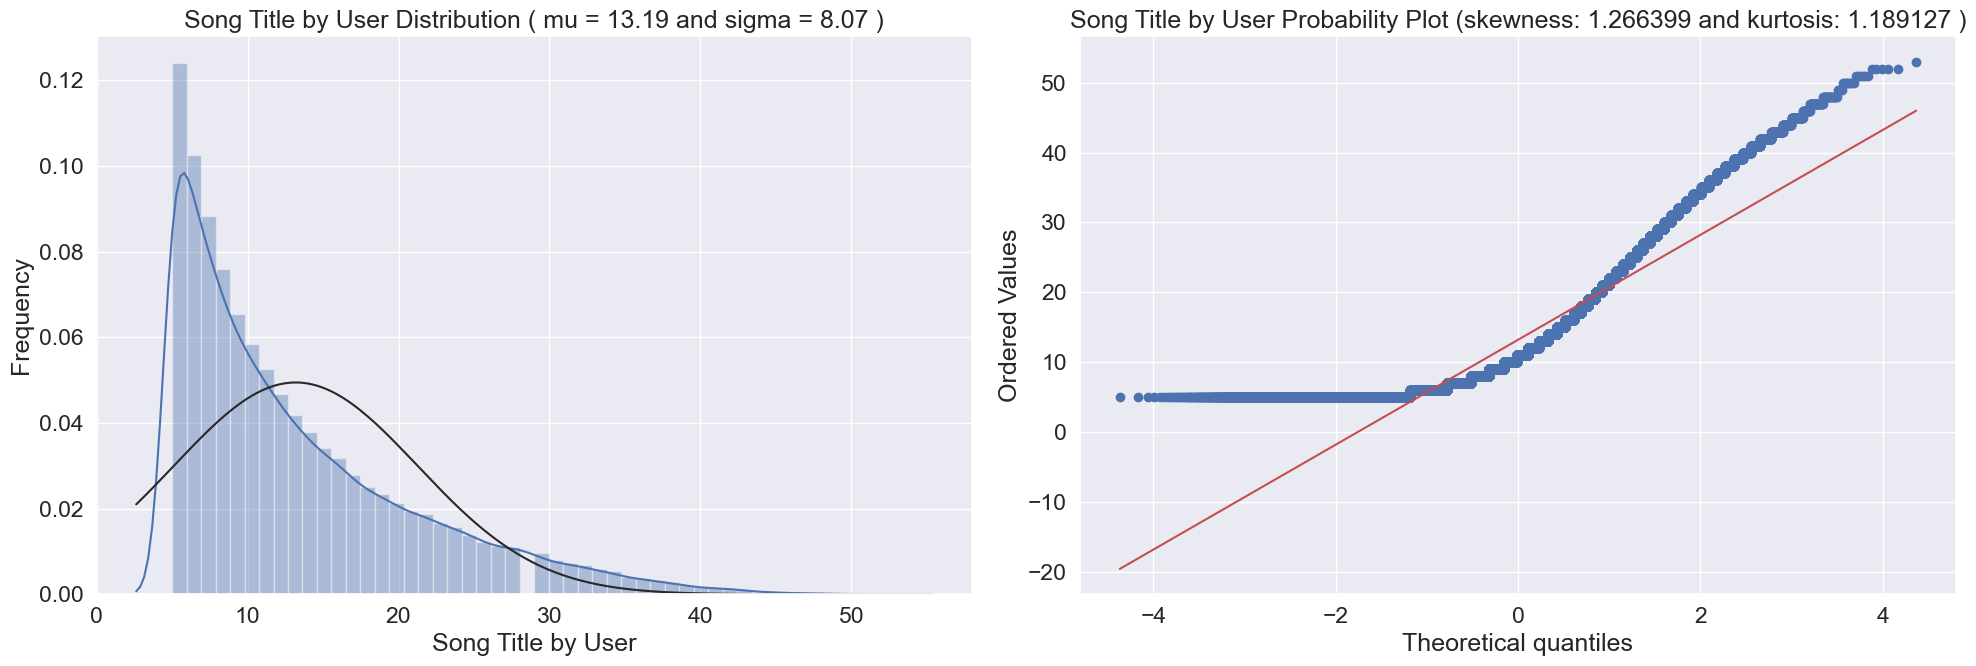

,0,1,2,3,4,5,6,7
index,count,mean,std,min,25%,50%,75%,max
title,110000,13.1903,8.07083,5,7,11,17,53


In [42]:
user_song_count_distribution = song_data[['user','title']].groupby('user').count().\
                                reset_index().sort_values(by='title',ascending = False)

def QQ_plot(data, measure):
    fig = plt.figure(figsize=(20,7))

    #Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(data)

    #Kernel Density plot
    fig1 = fig.add_subplot(121)
    sns.distplot(data, fit=norm)
    fig1.set_title(measure + ' Distribution ( mu = {:.2f} and sigma = {:.2f} )'.format(mu, sigma), loc='center')
    fig1.set_xlabel(measure)
    fig1.set_ylabel('Frequency')

    #QQ plot
    fig2 = fig.add_subplot(122)
    res = probplot(data, plot=fig2)
    fig2.set_title(measure + ' Probability Plot (skewness: {:.6f} and kurtosis: {:.6f} )'.format(data.skew(), data.kurt()), loc='center')

    plt.tight_layout()
    plt.show()
    
QQ_plot(user_song_count_distribution.title, 'Song Title by User')
user_song_count_distribution.title.describe().reset_index().T

From the first graph above we can see that song title by user distribution is skewed, has a peak on the left and a long tail to the right. It deviates from normal distribution and is somewhat positively biased.

From the Probability Plot, we could see that song title by user also does not align with the diagonal red line which represent normal distribution. The form of its distribution confirm that is a skewed right.

With skewness positive of 1.26, we confirm the lack of symmetry and indicate that song title by user are skewed right, as we can see too at the song title by user distribution plot, skewed right means that the right tail is long relative to the left tail, as we expect in counts. The skewness for a normal distribution is zero, and any symmetric data should have a skewness near zero. A distribution, or data set, is symmetric if it looks the same to the left and right of the center point.

Kurtosis is a measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution. That is, data sets with high kurtosis tend to have heavy tails, or outliers, and positive kurtosis indicates a heavy-tailed distribution and negative kurtosis indicates a light tailed distribution. So, with 1.18 of positive kurtosis song title by user are acceptable, although we can accept the kurtosis within 3.


In [43]:
data = song_data.copy()

In [44]:
bins = [0, 1, 5, 10, 25, 50, 100, 200, 400, 1000]
data['binned'] = pd.cut(data['play_count'], bins, 
                         labels=['1_time', '2-5_times', '6-10_times', '11-25_times', '26-50_times', '51-100_times',
                                '101-200_times', '201-400_times', '400+_times'])

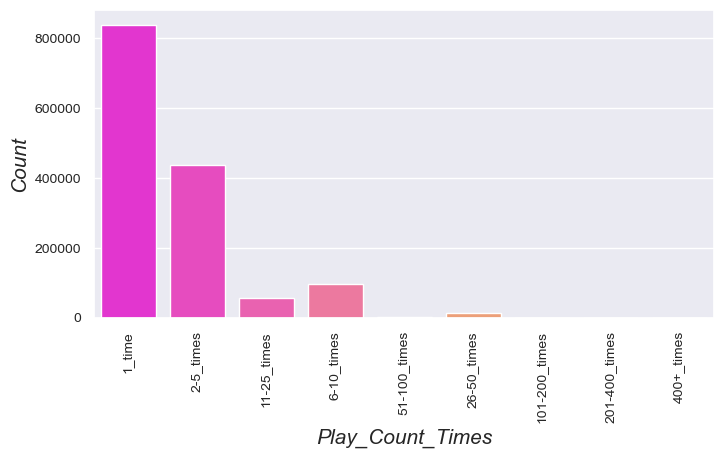

In [45]:
plt.figure(figsize=(8,4))
sns.countplot(data['binned'].astype('str'), data=data, palette='spring')
plt.xticks(fontsize=10)
plt.xticks(rotation=90)
plt.yticks(fontsize=10)
plt.xlabel('Play_Count_Times', fontsize=15, style='oblique')
plt.ylabel('Count', fontsize=15, style='oblique')
plt.show()

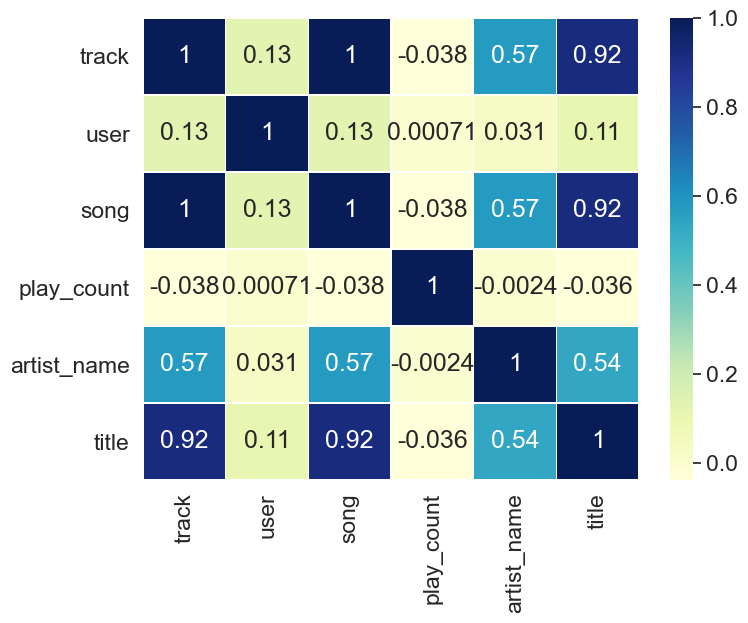

In [46]:
plt.figure(figsize=(8, 6))
mask = np.array(song_data.corr())
mask[np.tril_indices_from(mask)]=False
corr = song_data.apply(lambda x: pd.factorize(x)[0]).corr()
ax = sns.heatmap(corr, xticklabels=corr.columns, annot=True,yticklabels=corr.columns, 
                 linewidths=.2,cmap="YlGnBu")

### pd.factorize ?

Pandas series is a One-dimensional ndarray with axis labels. ... Pandas Series. factorize() function encode the object as an enumerated type or categorical variable. This method is useful for obtaining a numeric representation of an array when all that matters is identifying distinct values.

In [47]:
song_data.apply(lambda x: pd.factorize(x)[0]).corr()

,track,user,song,play_count,artist_name,title
track,1.000000,0.126456,1.000000,-0.037674,0.574752,0.920018
user,0.126456,1.000000,0.126456,0.000708,0.030958,0.109398
song,1.000000,0.126456,1.000000,-0.037674,0.574752,0.920018
play_count,-0.037674,0.000708,-0.037674,1.000000,-0.002404,-0.035997
artist_name,0.574752,0.030958,0.574752,-0.002404,1.000000,0.536171
title,0.920018,0.109398,0.920018,-0.035997,0.536171,1.000000


In [48]:
song_data.to_csv('song_data.csv',index=False)

In [49]:
song_data = pd.read_csv("clean_df.csv")
song_data.head(2)

,user,play_count,Track_Id,Song_Id,Artist_Name,Title,Song
0,d7083f5e1d50c264277d624340edaaf3dc16095b,1,TRCQXMT128E0786397,SOUVUHC12A67020E3B,Moby,Lift Me Up,Lift Me Up - Moby
1,d7083f5e1d50c264277d624340edaaf3dc16095b,1,TRIKCQI128F92DDC16,SOIPJAX12A8C141A2D,Guano Apes,Open Your Eyes,Open Your Eyes - Guano Apes


In [50]:
# cummulative sum of listen count of the songs

#song_grouped = song_data.groupby(['Song',]).agg({'play_count':'count'}).sort_values('play_count', ascending=False).reset_index()
#song_grouped.head(50) 

In [51]:
#grouped_sum = song_grouped['play_count'].sum()
#song_grouped['percentage']  = song_grouped['play_count'].div(grouped_sum)*100
#song_grouped.sort_values(['play_count', 'Song'], ascending = [0,1])

In [52]:
users = song_data['user'].unique()
len(users)

99681

In [53]:
songs = song_data['Song'].unique()
len(songs)

29859

In [54]:
data = song_data.copy()

Recommendation Engine
The basis of the recommendation engine is always the recorded interaction between the users and products.

Types of Recommendation Engines
The major area of distinction in different recommendation engines comes from the entity that they assume is the most important in the process of generating recommendations.

User-based recommendation engines: With the user as the central entity, the algorithm will look for similarities among users and on the basis of those similarities will come up with the recommendation.
Content-based recommendation engines: With the content that we are trying to recommend as central entity, the algorithm will attempt to find features about the content and find similar content. Then these similarities will be used to make recommendations to the end users.
Hybrid-recommendation engines: Sometimes termed as collaborative filtering recommendation engines, these are one of the most effective classes of recommendation engines, as they take the best features of both classes, users and content of recommendation engines.

Popularity-Based Recommendation Engine
The most simplest recommendation engine is the Popularity-Based, that basically standing, if some item is liked by a vast majority of our user base, then it is a good idea to recommend that item to users who have not interacted with that item. The code to develop this kind of recommendation is extremely easy and is effectively just a summarization procedure that determine which items of the content have the most users and then that will become our standard recommendation set for each user.

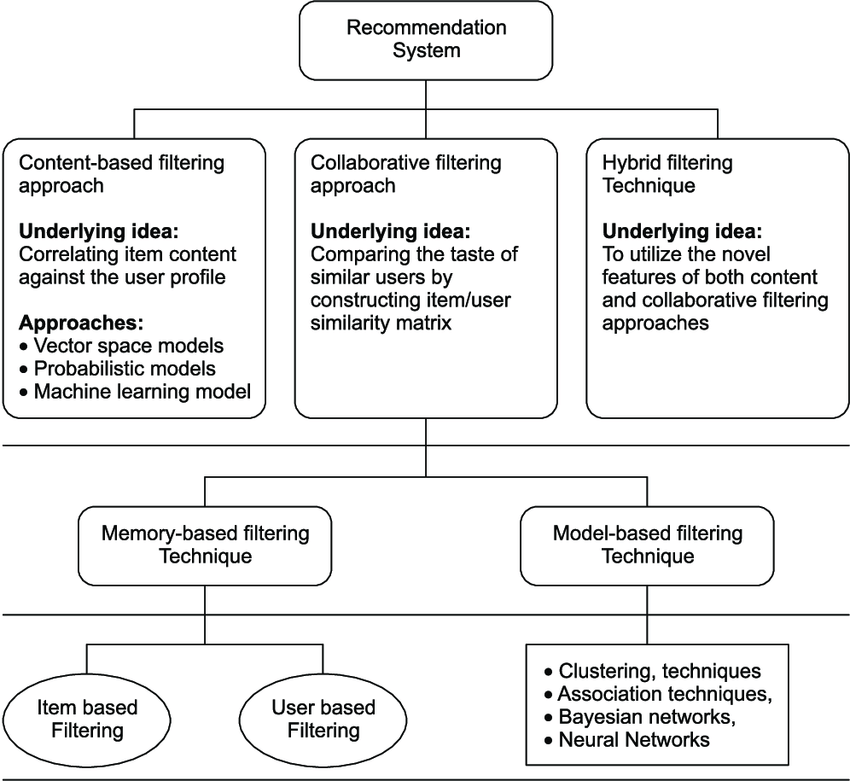

## 1. Popularity-Based Recommenndation System

It is a type of recommendation system which works on the principle of popularity and or anything which is in trend. These systems check about the product or movie which are in trend or are most popular among the users and directly recommend those.

 

For example, if a product is often purchased by most people then the system will get to know that that product is most popular so for every new user who just signed it, the system will recommend that product to that user also and chances becomes high that the new user will also purchase that. 

 **Merits of popularity based recommendation system**
 
* It does not suffer from cold start problems which means on day 1 of the business also it can recommend products on various different filters.

* There is no need for the user's historical data.

 

 **Demerits of popularity based recommendation system**
 

* Not personalized 

* The system would recommend the same sort of products/movies which are solely based upon popularity to every other user.

 

 **Example**
 

* Google News: News filtered by trending and most popular news.

* YouTube: Trending videos.

For more to learn, you can look at Google News which is filtered by popular and trending news here.
https://news.google.com/topstories?hl=en-IN&gl=IN&ceid=IN%3Aen

For more detail about Recommendation system : https://getintorecommendation.blogspot.com/

**Cold start** happens when new users or new items arrive in e-commerce platforms. Classic recommender systems like collaborative filtering assumes that each user or item has some ratings so that we can infer ratings of similar users/items even if those ratings are unavailable. However, for new users/items, this becomes hard because we have no browse, click or purchase data for them. As a result, we cannot “fill in the blank” using typical matrix factorization techniques.

Fortunately, researchers have proposed various ways to tackle this cold start problem.

Approaches
* Representative based: use subset of items and users that represents the population
* Content based: use side information such as text, social networks, etc.
* Bandit: consider the exploration vs exploitation tradeoffs in new items.
* Deep learning: recent methods that tries to solve some of the issues tackled above but using a black box.

In [55]:
def create_popularity_recommendation(data, user, Song_Id, n=10):
    #Get a count of user_ids for each unique song as recommendation score
    data_grouped = data.groupby([Song_Id]).agg({user: 'count'}).reset_index()
    data_grouped.rename(columns = {user: 'score'},inplace=True)
    
    #Sort the songs based upon recommendation score
    data_sort = data_grouped.sort_values(['score', Song_Id], ascending = [0,1])
    
    #Generate a recommendation rank based upon score
    data_sort['Rank'] = data_sort.score.rank(ascending=False, method='first')
        
    #Get the top n recommendations
    popularity_recommendations = data_sort.head(n)
    return popularity_recommendations

In [56]:
recommendations = create_popularity_recommendation(data,'user','Title', 20)
display(recommendations)

,Title,score,Rank
19705,Sehr kosmisch,4801,1.0
25174,Undo,4312,2.0
27347,You're The One,4082,3.0
5673,Dog Days Are Over (Radio Edit),3593,4.0
18759,Revelry,3527,5.0
19666,Secrets,3292,6.0
9828,Horn Concerto No. 4 in E flat K495: II. Romanc...,3113,7.0
9551,Hey_ Soul Sister,2693,8.0
7462,Fireflies,2619,9.0
24384,Tive Sim,2526,10.0


We can use our popularity recommendation function to find the 20 artists recommendations too.

In [57]:
display(create_popularity_recommendation(song_data,'user','Artist_Name', 20))

,Artist_Name,score,Rank
1859,Coldplay,11736,1.0
4873,Kings Of Leon,8086,2.0
3163,Florence + The Machine,7912,3.0
4623,Justin Bieber,7368,4.0
4051,Jack Johnson,6571,5.0
8484,The Black Keys,6288,6.0
9432,Train,6288,7.0
2816,Eminem,5970,8.0
6552,OneRepublic,5773,9.0
6172,Muse,5551,10.0


## 2. Content-Based Recommendation System


It is another type of recommendation system which works on the principle of similar content. If a user is watching a movie, then the system will check about other movies of similar content or the same genre of the movie the user is watching. There are various fundamentals attributes that are used to compute the similarity while checking about similar content. 

**Cosine Similarity:**

Cosine of the angle between the two vectors of the item, vectors of A and B is calculated for imputing similarity. If the vectors are closer, then small will be the angle and large will be the cosine
$$ Similarity(X,Y) = \frac{X.Y}{|X|*|Y|} $$

**Jaccard Similarity:**

Users who have rated item A and B divided by the total number of users who have rated either A or B gives us the similarity. It is used for comparing the similarity.

**Merits**
* There is no requirement for much of the user’s data.

* We just need item data that enable us to start giving recommendations to users.

* A content-based recommender engine does not depend on the user’s data, so even if a new user comes in, we can recommend the user as long as we have the user data to build his profile.

* It does not suffer from a cold start.

 

**Demerits**
 

* Items data should be in good volume.

* Features should be available to compute the similarity.

### Item Similarity Based Recommendation Engine
To provide a more personal recommendation to the user we need apply a recommendation engine that consider some kind of similarities between users and theirs items. In other words, it is a recommendation engine based on calculating similarities between a user's items and the other items in our dataset. Usually to define similarity among a set of items, we need a feature set on the basis of which both items can be described. In our case it will mean features of the songs on the basis of which one song can be differentiated from another.

Since our dataset don't have this data, we can use the the Jaccard index to do an implicit similarity, based on common users, in terms of the users who listen to these songs. The Jaccard coefficient measures similarity between finite sample sets, and is defined as the size of the intersection divided by the size of the union of the sample sets:

$$J(A,B) = \frac{|A\cap B|}{|A\cup B|} = \frac{|A\cap B|}{|A|+|B|-|A\cap B|}$$


The basic idea remains that if two songs are being listened to by a large fraction of common users out of the total listeners, the two songs can be said to be similar to each other.

So, we need calculate the similarity of each song in the user's list to those in our dataset, using the similarity metric defined previously, but we need attention to it can become a computation-intensive step when we have a large number of songs. To make the computation more feasible,probably you use a cluster or, in our case, we limited ours items to random 50% songs so it is quite unlikely that we would miss out on any important recommendations.

https://en.wikipedia.org/wiki/Jaccard_index

In [58]:
sample_data = song_data.sample(frac=0.50)

In [59]:
sample_data.shape

(530318, 7)

In [60]:
total_play_count = sum(sample_data.play_count)
play_count = sample_data[['Song_Id', 'play_count']].groupby('Song_Id').sum().\
             sort_values(by='play_count',ascending=False)
print('5,000 most popular songs represents {:3.2%} of total listen.'.format(float(play_count.sum())/total_play_count))


song_subset = list(play_count.index[:530318])
user_subset = list(sample_data.loc[sample_data.Song_Id.isin(song_subset), 'user'].unique())
user_song_list_count_sub = sample_data[sample_data.Song_Id.isin(song_subset)]
display(user_song_list_count_sub.head())

5,000 most popular songs represents 100.00% of total listen.


,user,play_count,Track_Id,Song_Id,Artist_Name,Title,Song
1057097,474977b3df68ec63e9372e5819d41152be08c22b,2,TRQLFPH128F92DE1A0,SOMFTUN12A6D4F60A5,Arctic Monkeys,Teddy Picker,Teddy Picker - Arctic Monkeys
646813,1859e525cba8ffb72c1b5319577217f608fa1c01,2,TRSUSWW128F93463BF,SOBADEB12AB018275F,Black Eyed Peas,Imma Be,Imma Be - Black Eyed Peas
33308,a10c1c97952613bd91d51955359e26a430dcd4fd,5,TRUGIOJ128F14A8410,SOLWOTK12A6D4FABAD,Mama's Jasje,Keer Op Keer,Keer Op Keer - Mama's Jasje
877323,ac38ce8b1a6e1cc0d297ef3b3e407c1cecde8e69,1,TRZBJBL128F92D9B53,SOTSHYT12A8C142868,Phoenix,Rome,Rome - Phoenix
17142,68d61562cba4b6ff817d6fbf32aac55773a93e2f,2,TRJHHHD128F428BC90,SOLGZMY12A58A7A6DD,Enrique Iglesias,DÃ­melo,DÃ­melo - Enrique Iglesias


In [61]:
#total_play_count = sum(song_data.play_count)
#play_count = song_data[['Song_Id', 'play_count']].groupby('Song_Id').sum().\
             #sort_values(by='play_count',ascending=False).head(5000)

#print('5,000 most popular songs represents {:3.2%} of total listen.'.format(float(play_count.sum())/total_play_count))

#song_subset = list(play_count.index[:5000])
#user_subset = list(song_data.loc[song_data.Song_Id.isin(song_subset), 'user'].unique())
#user_song_list_count_sub = song_data[song_data.Song_Id.isin(song_subset)]
#display(user_song_list_count_sub.head())

In [62]:
train_data, test_data = train_test_split(sample_data, test_size = 0.20, random_state=0)
print(train_data.head(5))

                                            user  play_count  \
594009  5370abc0717d0ceba878b499e93fb151a68c400d           1   
36065   d848af124f7325c9852d8eb58ca111f5158ef07d           1   
616793  cdd8ca44d6e3217b575ab64fac82473f5f4f325a           2   
898314  5218cc412e2c6ed50aeb8e072f848da1c79016e1           4   
43253   2324de608ce75a55b7abbda753423e9d57bb9959           1   

                  Track_Id             Song_Id                Artist_Name  \
594009  TROIBHC128F14958FC  SOJYFST12A6D4F9DE8             Bell Biv DeVoe   
36065   TRJWVCU128F14581FF  SONQCXC12A6D4F6A37              Sheena Easton   
616793  TRRBXPD128F422F19C  SOXCWSQ12A6D4FDC8E  Between The Buried And Me   
898314  TRLAEWG128F4227F4C  SOFPSZV12A6D4FBBFA                 Yael NaÃ¯m   
43253   TRCPEXY128F92F064A  SOMMUKQ12AB01801A5                 Nickelback   

                                        Title  \
594009                                 Poison   
36065           Strut (1993 Digital Remaster)   
61679

In [63]:
##Class for Popularity based Recommender System model
##class popularity_recommender_py():
    #def __init__(self):
        #self.train_data = None
        #self.user_id = None
        #self.item_id = None
        #self.popularity_recommendations = None
        
    ##Create the popularity based recommender system model
    #def create(self, train_data, user, Song_Id):
        #self.train_data = train_data
        #self.user_id = user
        #self.item_id = Song_Id

        ##Get a count of user_ids for each unique song as recommendation score
        #train_data_grouped = train_data.groupby([self.item_id]).agg({self.user_id: 'count'}).reset_index()
        #train_data_grouped.rename(columns = {'user_id': 'score'},inplace=True)
    
        #####Sort the songs based upon recommendation score
        #train_data_sort = train_data_grouped.sort_values(['score', self.item_id], ascending = [0,1])
    
        ###Generate a recommendation rank based upon score
        #train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0, method='first')
        #Get the top 10 recommendations
        #self.popularity_recommendations = train_data_sort.head(10)

        ###Use the popularity based recommender system model to
    ####make recommendations
    #def recommend(self, user):    
        #user_recommendations = self.popularity_recommendations
        
        ###Add user_id column for which the recommendations are being generated
        #user_recommendations['user_id'] = user
    
        ###Bring user_id column to the front
        #cols = user_recommendations.columns.tolist()
        #cols = cols[-1:] + cols[:-1]
        #user_recommendations = user_recommendations[cols]
        
        #return user_recommendations

In [64]:
class item_similarity_recommender_py():
    def __init__(self):
        self.train_data = None
        self.user_id = None
        self.item_id = None
        self.cooccurence_matrix = None
        self.songs_dict = None
        self.rev_songs_dict = None
        self.item_similarity_recommendations = None
        
    #Get unique items (songs) corresponding to a given user
    def get_user_items(self, user):
        user_data = self.train_data[self.train_data[self.user_id] == user]
        user_items = list(user_data[self.item_id].unique())
        
        return user_items
        
    #Get unique users for a given item (song)
    def get_item_users(self, Song):
        item_data = self.train_data[self.train_data[self.item_id] == Song]
        item_users = set(item_data[self.user_id].unique())
            
        return item_users
    
        #Get unique items (songs) in the training data
    def get_all_items_train_data(self):
        all_items = list(self.train_data[self.item_id].unique())
            
        return all_items
        
    #Construct cooccurence matrix
    def construct_cooccurence_matrix(self, user_songs, all_songs):
            
        ####################################
        #Get users for all songs in user_songs.
        ####################################
        user_songs_users = []        
        for i in range(0, len(user_songs)):
            user_songs_users.append(self.get_item_users(user_songs[i]))
            
            
             ###############################################
        #Initialize the item cooccurence matrix of size 
        #len(user_songs) X len(songs)
        ###############################################
        cooccurence_matrix = np.matrix(np.zeros(shape=(len(user_songs), len(all_songs))), float)
        
        #############################################################
        #Calculate similarity between user songs and all unique songs
        #in the training data
        #############################################################
        for i in range(0,len(all_songs)):
            #Calculate unique listeners (users) of song (item) i
            songs_i_data = self.train_data[self.train_data[self.item_id] == all_songs[i]]
            users_i = set(songs_i_data[self.user_id].unique())
            
            for j in range(0,len(user_songs)):       
                    
                #Get unique listeners (users) of song (item) j
                users_j = user_songs_users[j]
                    
                #Calculate intersection of listeners of songs i and j
                users_intersection = users_i.intersection(users_j)
                
                #Calculate cooccurence_matrix[i,j] as Jaccard Index
                if len(users_intersection) != 0:
                    #Calculate union of listeners of songs i and j
                    users_union = users_i.union(users_j)
                    
                    cooccurence_matrix[j,i] = float(len(users_intersection))/float(len(users_union))
                else:
                    cooccurence_matrix[j,i] = 0
                    
                return cooccurence_matrix
            
            
      #Use the cooccurence matrix to make top recommendations
    def generate_top_recommendations(self, user, cooccurence_matrix, all_songs, user_songs):
        print("Non zero values in cooccurence_matrix :%d" % np.count_nonzero(cooccurence_matrix))
        
        #Calculate a weighted average of the scores in cooccurence matrix for all user songs.
        user_sim_scores = cooccurence_matrix.sum(axis=0)/float(cooccurence_matrix.shape[0])
        user_sim_scores = np.array(user_sim_scores)[0].tolist()
 
        #Sort the indices of user_sim_scores based upon their value
        #Also maintain the corresponding score
        sort_index = sorted(((e,i) for i,e in enumerate(list(user_sim_scores))), reverse=True)
    
        #Create a dataframe from the following
        columns = ['user_id', 'song', 'score', 'rank']
        #index = np.arange(1) # array of numbers for the number of samples
        df = pd.DataFrame(columns=columns)
         
        #Fill the dataframe with top 10 item based recommendations
        
        rank = 1 
        for i in range(0,len(sort_index)):
            if ~np.isnan(sort_index[i][0]) and all_songs[sort_index[i][1]] not in user_songs and rank <= 10:
                df.loc[len(df)]=[user,all_songs[sort_index[i][1]],sort_index[i][0],rank]
                rank = rank+1
        
        #Handle the case where there are no recommendations
        if df.shape[0] == 0:
            print("The current user has no songs for training the item similarity based recommendation model.")
            return -1
        else:
            return df
 
    #Create the item similarity based recommender system model
    def create(self, train_data, user, Song_Id):
        self.train_data = train_data
        self.user_id = user
        self.item_id = Song_Id                       #......................................................................

    #Use the item similarity based recommender system model to
    #make recommendations
    def recommend(self, user):
        ########################################
        #A. Get all unique songs for this user
        ########################################
        user_songs = self.get_user_items(user)    
            
        print("No. of unique songs for the user: %d" % len(user_songs))
        
        ######################################################
        #B. Get all unique items (songs) in the training data
        ######################################################
        all_songs = self.get_all_items_train_data()
        
        print("no. of unique songs in the training set: %d" % len(all_songs))
         
        ###############################################
        #C. Construct item cooccurence matrix of size 
        #len(user_songs) X len(songs)
        ###############################################
        cooccurence_matrix = self.construct_cooccurence_matrix(user_songs, all_songs)
        
        
        #######################################################
        #D. Use the cooccurence matrix to make recommendations
        #######################################################
        df_recommendations = self.generate_top_recommendations(user, cooccurence_matrix, all_songs, user_songs)
                
        return df_recommendations
    
    #Get similar items to given items
    def get_similar_items(self, item_list):
        
        user_songs = item_list
        
        ######################################################
        #B. Get all unique items (songs) in the training data
        ######################################################
        all_songs = self.get_all_items_train_data()
        
        print("no. of unique songs in the training set: %d" % len(all_songs))
         
        ###############################################
        #C. Construct item cooccurence matrix of size 
        #len(user_songs) X len(songs)
        ###############################################
        cooccurence_matrix = self.construct_cooccurence_matrix(user_songs, all_songs)
        
        #######################################################
        #D. Use the cooccurence matrix to make recommendations
        #######################################################
        user = ""
        df_recommendations = self.generate_top_recommendations(user, cooccurence_matrix, all_songs, user_songs)
         
        return df_recommendations

For more detail of Co occurance matrix: https://getintorecommendation.blogspot.com/2021/06/co-occurance-matrix.html

In [65]:
is_model = item_similarity_recommender_py()
is_model.create(user_song_list_count_sub, 'user', 'Title')
user_id = list(user_song_list_count_sub.user)[12]
user_items = is_model.get_user_items(user_id)

#Recommend songs for the user using personalized model
is_model.recommend(user_id)

No. of unique songs for the user: 6
no. of unique songs in the training set: 26957
Non zero values in cooccurence_matrix :0


,user_id,song,score,rank
0,312b3cf41a0a508eece0db5e336f64ca0aef3ccb,Van iz grada,0.0,1
1,312b3cf41a0a508eece0db5e336f64ca0aef3ccb,Double Decker (Deck The Halls),0.0,2
2,312b3cf41a0a508eece0db5e336f64ca0aef3ccb,Goin' Up Yonder,0.0,3
3,312b3cf41a0a508eece0db5e336f64ca0aef3ccb,Old world,0.0,4
4,312b3cf41a0a508eece0db5e336f64ca0aef3ccb,If I had wings,0.0,5
5,312b3cf41a0a508eece0db5e336f64ca0aef3ccb,Heart Of Steel,0.0,6
6,312b3cf41a0a508eece0db5e336f64ca0aef3ccb,SoÃ±ador Eterno,0.0,7
7,312b3cf41a0a508eece0db5e336f64ca0aef3ccb,Jagged Melody,0.0,8
8,312b3cf41a0a508eece0db5e336f64ca0aef3ccb,I Don't Want To Fall,0.0,9
9,312b3cf41a0a508eece0db5e336f64ca0aef3ccb,Only In America,0.0,10


As you can see, although the algorithms seem to have done a good job of customizing the recommendations, it is clear that we can improve them, so we go to the next recommendation system a bit more complex.

In [66]:
song_data.head()

,user,play_count,Track_Id,Song_Id,Artist_Name,Title,Song
0,d7083f5e1d50c264277d624340edaaf3dc16095b,1,TRCQXMT128E0786397,SOUVUHC12A67020E3B,Moby,Lift Me Up,Lift Me Up - Moby
1,d7083f5e1d50c264277d624340edaaf3dc16095b,1,TRIKCQI128F92DDC16,SOIPJAX12A8C141A2D,Guano Apes,Open Your Eyes,Open Your Eyes - Guano Apes
2,d7083f5e1d50c264277d624340edaaf3dc16095b,1,TRXNEZC128F42633B8,SOATCSU12A8C13393A,moe.,Happy Hour Hero,Happy Hour Hero - moe.
3,d7083f5e1d50c264277d624340edaaf3dc16095b,1,TRJSZYC128F426DBBB,SOZPZGN12A8C135B45,Bahramji & Maneesh De Moor,Dreamcatcher,Dreamcatcher - Bahramji & Maneesh De Moor
4,d7083f5e1d50c264277d624340edaaf3dc16095b,1,TRJQUWB128F14ADBF7,SOPFVWP12A6D4FC636,Michael Card,Sleep Sound In Jesus,Sleep Sound In Jesus - Michael Card


#### Content Based with coine similarity

In [163]:
#sam_data = song_data.sample(frac = 0.005)

In [164]:
#sam_data.shape

In [162]:
#from sklearn.feature_extraction.text import CountVectorizer
#cv = CountVectorizer()
#count_matrix = cv.fit_transform(sam_data["Song"])

In [161]:
#from sklearn.metrics.pairwise import cosine_similarity
#cos_sim = cosine_similarity(count_matrix)
#print((cos_sim))

In [160]:
#def get_title_from_index(index):
    #return sam_data[sam_data.index==index]['Title'].value[0]
#def get_index_from_title(Artist_Name):
    
    #return sam_data[sam_data.Title==Artist_Name].index[0]

In [159]:
#sam_data.head()

In [158]:
#song_user_like= "Now Behold The Lamb"
#song_index = get_index_from_title(song_user_like)

#similar_songs = list(enumerate(cos_sim[song_index]))

#print(list(set(similar_songs)))

## 3. Collaborative Filtering
 

It is considered to be one of the very smart recommender systems that work on the similarity between different users and also items that are widely used as an e-commerce website and also online movie websites. It checks about the taste of similar users and does recommendations. 

 

The similarity is not restricted to the taste of the user moreover there can be consideration of similarity between different items also. The system will give more efficient recommendations if we have a large volume of information about users and items.

**This is the way collaborative filtering works. Mainly, there are two approaches used in collaborative filtering stated below;**

### a) User-based nearest-neighbor collaborative filtering
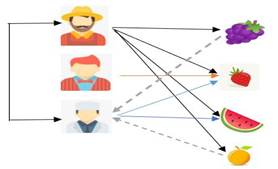

This Figure shows user X, Y, and Z respectively. The system checks the items that are similar to the items the user bought. The similarity between different items is computed based on the items and not the users for the prediction. Users X and Y both purchased items A and B so they are found to have similar tastes.

### b) Item-based nearest-neighbor collaborative filtering
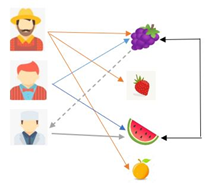

This Figure shows user X, Y, and Z respectively. The system checks the items that are similar to the items the user bought. The similarity between different items is computed based on the items and not the users for the prediction. Users X and Y both purchased items A and B so they are found to have similar tastes.

**Limitations**
 

* Enough users required to find a match. To overcome such cold start problems, often hybrid approaches are made use of between CF and Content-based matching.

* Even if there are many users and many items that are to be recommended often, problems can arise of user and rating matrix to be sparse and will become challenging to find out about the users who have rated the same item.

* The problem in recommending items to the user due to sparsity problems.

## c) Singular value decomposition and matrix-factorization
 

Singular value decomposition also known as the SVD algorithm is used as a collaborative filtering method in recommendation systems. SVD is a matrix factorization method that is used to reduce the features in the data by reducing the dimensions from N to K where (K<N). 

 

For the part of the recommendation, the only part which is taken care of is matrix factorization that is done the user-item rating matrix. Matrix-factorization is all about taking 2 matrices whose product is the original matrix. Vectors are used to represent item ‘qi’ and user ‘pu’ such that their dot product is the expected rating. 

## Matrix factorization based recommendations

Matrix factorization based recommendation engines) are probably the most used recommendation engines when it comes to implementing recommendation engines in production.

Matrix factorization are methods that reduce a matrix into constituent parts, such that when these matrices are multiplied we get the original matrix. It make it easier to calculate more complex matrix operations. Matrix factorization methods, also called matrix decompositions methods, are a foundation of linear algebra in computers, even for basic operations such as solving systems of linear equations, calculating the inverse, and calculating the determinant of a matrix.

Matrix factorization can be used to discover latent features between two different kinds of entities. For example, we can try to explain a song in mathematical terms by measuring its beats, tempo, and other such features and then define similar features in terms of the user. Once we have consciously defined such "features", we can use them to find matches for a user based on some similarity criteria. You can use matrix factorization to discover these latent features and they seem to work great.

The starting point of any matrix factorization-based method is the utility matrix, a matrix of user Vs item dimension. Not, this is a sparse matrix, since not all item is used by the user. The process of matrix factorization means finding out a low rank approximation of the utility matrix. So we want to break down the utility matrix U into two low rank matrices so that we can recreate the matrix U by multiplying those two matrices:

Assuming the process helps us identify latent factors/features, meaning as K, our aim is to find two matrices X and Y such that their product (matrix multiplication) approximates R.

X = |U| x K matrix (A matrix with dimensions of num_users * factors)

Y = |P| x K matrix (A matrix with dimensions of factors * num_songs)

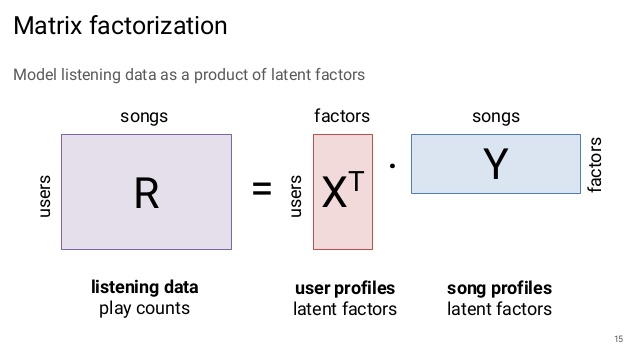

To make a recommendation to the user, we can multiply the corresponding user's row from the first matrix by the item matrix and determine the items from the row with maximum ratings. That will become our recommendations for the user. The first matrix represents the association between the users and the latent features, while the second matrix takes care of the associations between items (songs in our case) and the latent features.

**Matrix Factorization and Singular Value Decomposition (SVD)**
<p>There are multiple algorithms available for determining factorization of any matrix. We use one of the simplest algorithms, which is the singular value decomposition or SVD. You can follow these steps to determine the factorization of a matrix using the output of SVD function.

Factorize the matrix to obtain U, S, and V matrices.
Reduce the matrix S to first k components. (The function we are using will only provide k dimensions, so we can skip this step.)
Compute the square root of reduced matrix $S_k$ to obtain the matrix $S_k^{1/2}$.
Compute the two resultant matrix $U*S_k{1/2}$ and $S_k^{1/2}*V$ as these will serve as our two factorized matrices
We can then generate the prediction of user i for product j by taking the dot product of the ith row of the first matrix with the jth column of the second matrix.

Let's create tree functions to help us on it:

* **compute_svd:** It use the svds function provided by the scipy library to break down our utility matrix into three different matrices, and prosed with the others tree steps above.
* **compute_estimated_matrix:** use the decomposed matrices by SVD and provide the predictions.

In [74]:
def compute_svd(urm, K):
    U, s, Vt = svds(urm, K)

    dim = (len(s), len(s))
    S = np.zeros(dim, dtype=np.float32)
    for i in range(0, len(s)):
        S[i,i] = mt.sqrt(s[i])

    U = csc_matrix(U, dtype=np.float32)
    S = csc_matrix(S, dtype=np.float32)
    Vt = csc_matrix(Vt, dtype=np.float32)
    
    return U, S, Vt

def compute_estimated_matrix(urm, U, S, Vt, uTest, K, test):
    rightTerm = S*Vt 
    max_recommendation = 250
    estimatedRatings = np.zeros(shape=(MAX_UID, MAX_PID), dtype=np.float16)
    recomendRatings = np.zeros(shape=(MAX_UID,max_recommendation ), dtype=np.float16)
    for userTest in uTest:
        prod = U[userTest, :]*rightTerm
        estimatedRatings[userTest, :] = prod.todense()
        recomendRatings[userTest, :] = (-estimatedRatings[userTest, :]).argsort()[:max_recommendation]
    return recomendRatings

def show_recomendations(uTest, num_recomendations = 10):
    for user in uTest:
        print('-'*70)
        print("Recommendation for user id {}".format(user))
        rank_value = 1
        i = 0
        while (rank_value <  num_recomendations + 1):
            so = uTest_recommended_items[user,i:i+1][0]
            if (small_set.user[(small_set.so_index_value == so) & (small_set.us_index_value == user)].count()==0):
                song_details = small_set[(small_set.so_index_value == so)].\
                    drop_duplicates('so_index_value')[['Title','Artist_Name']]
                print("The number {} recommended song is {} BY {}".format(rank_value, 
                                                                      list(song_details['Title'])[0],
                                                                      list(song_details['Artist_Name'])[0]))
                rank_value+=1
            i += 1

The first thing that we notice is that we have no concept of "rating" in our data. All we have are the play counts of various songs. This is a well known problem in the case of recommendation engines and is called the "implicit feedback" problem. There are many ways to solve this problem but we will look at a very simple and intuitive solution. We will replace the play count with a fractional play count. The logic being that this will measure the strength of "likeness" for a song in the range of [0,1].

In [75]:
sample_data

,user,play_count,Track_Id,Song_Id,Artist_Name,Title,Song
1057097,474977b3df68ec63e9372e5819d41152be08c22b,2,TRQLFPH128F92DE1A0,SOMFTUN12A6D4F60A5,Arctic Monkeys,Teddy Picker,Teddy Picker - Arctic Monkeys
646813,1859e525cba8ffb72c1b5319577217f608fa1c01,2,TRSUSWW128F93463BF,SOBADEB12AB018275F,Black Eyed Peas,Imma Be,Imma Be - Black Eyed Peas
33308,a10c1c97952613bd91d51955359e26a430dcd4fd,5,TRUGIOJ128F14A8410,SOLWOTK12A6D4FABAD,Mama's Jasje,Keer Op Keer,Keer Op Keer - Mama's Jasje
877323,ac38ce8b1a6e1cc0d297ef3b3e407c1cecde8e69,1,TRZBJBL128F92D9B53,SOTSHYT12A8C142868,Phoenix,Rome,Rome - Phoenix
17142,68d61562cba4b6ff817d6fbf32aac55773a93e2f,2,TRJHHHD128F428BC90,SOLGZMY12A58A7A6DD,Enrique Iglesias,DÃ­melo,DÃ­melo - Enrique Iglesias
...,...,...,...,...,...,...,...
356014,08257d5a6990036bcaf2a0e20bd9fa5293b4da38,1,TRTANNB128F4292027,SOXZWBG12A67ADFA70,Kosheen,Under Fire,Under Fire - Kosheen
645942,bb0b9d4384e770128341bba8d40da8f56f444c77,1,TRLCLWE128F92D426C,SOUMBOG12A8C1440C6,The Lonely Island / Natalie Portman / Chris Pa...,Natalie's Rap,Natalie's Rap - The Lonely Island / Natalie Po...
86655,e5219de9b832c0bb30eca290648318497e38f41d,1,TRKDDZW128F930B393,SOKMHKY12AF72AB079,Nickelback,How You Remind Me,How You Remind Me - Nickelback
651670,80a34f00ac3d51c0af8853632796964b3534cde9,11,TRLXMFO128F4241AF0,SOTOVIL12A8C133FAA,Flyleaf,Fully Alive,Fully Alive - Flyleaf


In [76]:
user_song_list_listen = sample_data[['user','play_count']].groupby('user').sum().reset_index()
user_song_list_listen.rename(columns={'play_count':'total_play_count'},inplace=True)
user_song_list_count_merged = pd.merge(sample_data,user_song_list_listen)
user_song_list_count_merged['fractional_play_count'] = \
    user_song_list_count_merged['play_count']/user_song_list_count_merged['total_play_count']

display(user_song_list_count_merged[user_song_list_count_merged.user =='841b2394ae3a9febbd6b06497b4a8ee8eb24b7f8']\
        [['user','Song_Id','play_count','fractional_play_count']].head())

,user,Song_Id,play_count,fractional_play_count
74859,841b2394ae3a9febbd6b06497b4a8ee8eb24b7f8,SOQCTEC12AB0186D7E,2,0.117647
74860,841b2394ae3a9febbd6b06497b4a8ee8eb24b7f8,SOAYGQW12AB017D6FA,1,0.058824
74861,841b2394ae3a9febbd6b06497b4a8ee8eb24b7f8,SOUAZDS12A8C13BA91,1,0.058824
74862,841b2394ae3a9febbd6b06497b4a8ee8eb24b7f8,SONLXZV12AC960A0B1,2,0.117647
74863,841b2394ae3a9febbd6b06497b4a8ee8eb24b7f8,SOYJUXS12AC95F02EF,1,0.058824


The next transformation of data that is required is to convert our dataframe into a numpy matrix in the format of utility matrix. We will convert our dataframe into a sparse matrix, as we will have a lot of missing values and sparse matrices are suitable for representation of such a matrix. Since we won't be able to transform our song IDs and user IDs into a numpy matrix, we will convert these indices into numerical indices. Then we will use these transformed indices to create our sparse numpy matrix.

In [77]:
user_codes = user_song_list_count_merged.user.drop_duplicates().reset_index()
user_codes.rename(columns={'index':'user_index'}, inplace=True)
user_codes['us_index_value'] = list(user_codes.index)

song_codes = user_song_list_count_merged.Song_Id.drop_duplicates().reset_index()
song_codes.rename(columns={'index':'song_index'}, inplace=True)
song_codes['so_index_value'] = list(song_codes.index)

small_set = pd.merge(user_song_list_count_merged,song_codes,how='left')
small_set = pd.merge(small_set,user_codes,how='left')
mat_candidate = small_set[['us_index_value','so_index_value','fractional_play_count']]

data_array = mat_candidate.fractional_play_count.values
row_array = mat_candidate.us_index_value.values
col_array = mat_candidate.so_index_value.values

data_sparse = coo_matrix((data_array, (row_array, col_array)),dtype=float)

display(data_sparse)

print('User used to performed the item similarity based recommendations earlie:.')
display(user_codes[user_codes.user =='841b2394ae3a9febbd6b06497b4a8ee8eb24b7f8'])

<97426x29297 sparse matrix of type '<class 'numpy.float64'>'
	with 530318 stored elements in COOrdinate format>

User used to performed the item similarity based recommendations earlie:.


,user_index,user,us_index_value
9831,74859,841b2394ae3a9febbd6b06497b4a8ee8eb24b7f8,9831


Once we have converted our matrix into a sparse matrix, we specify 50 as the number of latent factors we want to factorize our data and call ours functions first to compute the SVD, followed by the compute estimated matrix for the users ids sets by uTest variable:

**Note:** In recommender systems, we typically work with very sparse matrices as the item universe is very large while a single user typically interacts with a very small subset of the item universe.

In [78]:
sample_data.head(20)

,user,play_count,Track_Id,Song_Id,Artist_Name,Title,Song
1057097,474977b3df68ec63e9372e5819d41152be08c22b,2,TRQLFPH128F92DE1A0,SOMFTUN12A6D4F60A5,Arctic Monkeys,Teddy Picker,Teddy Picker - Arctic Monkeys
646813,1859e525cba8ffb72c1b5319577217f608fa1c01,2,TRSUSWW128F93463BF,SOBADEB12AB018275F,Black Eyed Peas,Imma Be,Imma Be - Black Eyed Peas
33308,a10c1c97952613bd91d51955359e26a430dcd4fd,5,TRUGIOJ128F14A8410,SOLWOTK12A6D4FABAD,Mama's Jasje,Keer Op Keer,Keer Op Keer - Mama's Jasje
877323,ac38ce8b1a6e1cc0d297ef3b3e407c1cecde8e69,1,TRZBJBL128F92D9B53,SOTSHYT12A8C142868,Phoenix,Rome,Rome - Phoenix
17142,68d61562cba4b6ff817d6fbf32aac55773a93e2f,2,TRJHHHD128F428BC90,SOLGZMY12A58A7A6DD,Enrique Iglesias,DÃ­melo,DÃ­melo - Enrique Iglesias
481196,3609f5d4ad68ab7c86883c5baab5c6b0fb312f6c,9,TRRYBQT128F42A6585,SOKNFWB12A6D4F8AA9,Ratt,Lay It Down (2007 Remastered),Lay It Down (2007 Remastered) - Ratt
806147,ce9d237ad283fb5ff2809cee52c382bdab835422,1,TRZSLAK128F149F9B0,SOIYHAZ12A6D4F6D30,MSTRKRFT,Easy Love,Easy Love - MSTRKRFT
296176,29830007121c802af4a175df015b483f60645d0f,1,TRCVCUS128F42838DD,SOHDSHF12A8C137530,Cat Stevens,Sitting,Sitting - Cat Stevens
74370,35e42acb1914847697027e9b2e3c3bac0ab857d1,3,TRUKLEK128F145AD15,SOJKKNF12A6D4F7696,Bobby McFerrin,Common Threads,Common Threads - Bobby McFerrin
569069,b11bad4e3a3e61c0478f32beb1e5a9d8af3ab084,1,TRDYYKS128F4275626,SOPOCCO12A58A7ADED,Octopus Project,Music Is Happiness,Music Is Happiness - Octopus Project


In [79]:
display(user_codes[user_codes.user =='d7083f5e1d50c264277d624340edaaf3dc16095b'])

,user_index,user,us_index_value
39474,279267,d7083f5e1d50c264277d624340edaaf3dc16095b,39474


In [80]:
K=50
urm = data_sparse
MAX_PID = urm.shape[1]              
MAX_UID = urm.shape[0]

U, S, Vt = compute_svd(urm, K)
uTest = [2,4,5,6,7,8,873,23]

uTest_recommended_items = compute_estimated_matrix(urm, U, S, Vt, uTest, K, True)

show_recomendations(uTest)

----------------------------------------------------------------------
Recommendation for user id 2
The number 1 recommended song is West One (Shine On Me) BY The Ruts
The number 2 recommended song is Hey Mama BY Kanye West
The number 3 recommended song is Nothin' On You [feat. Bruno Mars] (Album Version) BY B.o.B
The number 4 recommended song is Master Of Puppets BY Metallica
The number 5 recommended song is I CAN'T GET STARTED BY Ron Carter
The number 6 recommended song is The Voice BY Celtic Woman
The number 7 recommended song is Fuck Kitty BY Frumpies
The number 8 recommended song is Yellow BY Coldplay
The number 9 recommended song is Day 'N' Nite BY Kid Cudi Vs Crookers
The number 10 recommended song is Just Dance BY Lady GaGa / Colby O'Donis
----------------------------------------------------------------------
Recommendation for user id 4
The number 1 recommended song is Clocks BY Coldplay
The number 2 recommended song is Nothin' On You [feat. Bruno Mars] (Album Version) BY B.o.

In [81]:
#%matplotlib inline
#from pylab import *

##Plot all the users
#print("Matrix Dimensions for U")
#print(U.shape)

#for i in range(0, U.shape[0]):
    #plot(U[i,0], U[i,1], marker = "*", label="user"+str(i))

#for j in range(0, Vt.T.shape[0]):
    #plot(Vt.T[j,0], Vt.T[j,1], marker = 'd', label="item"+str(j))    
    
#legend(loc="upper right")
#title('User vectors in the Latent semantic space')
#ylim([-0.7, 0.7])
#xlim([-0.7, 0])
#show()

# Let's see some different Approaches of Collaborative Filtering 

### Memory_User_Based_RS_PD

Memory-Based Collaborative Filtering approaches can be divided into two main sections: user-item filtering and item-item filtering. A user-item filtering will take a particular user, find users that are similar to that user based on similarity of ratings, and recommend items that those similar users liked

In the memory-based approach, we try to predict a user’s preference based on the ratings given by other similar users or received by other similar items.

Memory-based approaches include: 

* user-based collaborative filtering,
* item-based collaborative filtering

In [82]:
from sklearn import preprocessing
from sklearn.metrics.pairwise import pairwise_distances 

In [83]:
song_data1 = song_data[['user', 'Song_Id', 'play_count', 'Title']]

In [84]:
song_data1.head(2)

,user,Song_Id,play_count,Title
0,d7083f5e1d50c264277d624340edaaf3dc16095b,SOUVUHC12A67020E3B,1,Lift Me Up
1,d7083f5e1d50c264277d624340edaaf3dc16095b,SOIPJAX12A8C141A2D,1,Open Your Eyes


In [85]:
song_data2 = song_data1.copy()

In [86]:
song_data1 = song_data1[:200000]


In [87]:
encoding_user_song = preprocessing.OrdinalEncoder()
song_data1['user_id'] = encoding_user_song.fit_transform(song_data1[['user']])
song_data1['song_id'] = encoding_user_song.fit_transform(song_data1[['Song_Id']])

In [88]:
song_data1['user_id'] = song_data1['user_id'].astype('int')
song_data1['song_id'] = song_data1['song_id'].astype('int')

In [89]:
train, test = train_test_split(song_data1, test_size=0.20, random_state=31)

In [90]:
train.head(2)

,user,Song_Id,play_count,Title,user_id,song_id
147986,be239a94479dc096e83b97b576234255eaa133f9,SOHHALP12A6D4FB6A8,1,Patience,14032,7738
114011,ac19cbe4bf3022654265ce776a15938cbc0b79cf,SORRCNC12A8C13FDA9,4,Is This It,12671,18538


In [91]:
song_data1.shape

(200000, 6)

In [92]:
print(train.shape, test.shape)

(160000, 6) (40000, 6)


In [93]:
n_users = song_data1.user.nunique()
n_items = song_data1.Song_Id.nunique()

In [94]:
print(n_users, n_items)

18728 26526


### User based Recommendation system 

#### Steps of user-based collaborative filtering:

* Firstly built a data matrix: (number of users in rows) x (number of items in column) and filled the values corresponding to the item rating given by a certain user.
* Secondly, from the above matrix, built the distance-wise pair matrix (user similarity) by using cosine similarity whose values indicate the similarities between the users. 
* Thirdly, applied the dot product of the data matrix with the user similarity matrix, which produces the ‘item_prediction’ matrix. It contains the user-ids in columns and item ids in rows.
* Finally, to predict the items to the user, the ‘item_prediction’ matrix was used by finding the column that corresponds to the user id.

#### Create empty data matrix: user*song 

In [95]:
data_matrix = np.zeros((n_users, n_items))

In [96]:
for line in train.itertuples():
    data_matrix[line[5]-1, line[6]-1] = line[3]

In [97]:
data_matrix.shape

(18728, 26526)

#### Pairwise distance with cosine metric 

In [98]:
user_similarity = 1 - pairwise_distances(data_matrix, metric='cosine')

In [99]:
np.unique(user_similarity)

array([0.00000000e+00, 9.26165671e-06, 9.94035507e-06, ...,
       9.99599664e-01, 9.99867701e-01, 1.00000000e+00])

In [100]:
user_similarity.shape

(18728, 18728)

#### Dot product of Data Matrix with User similarity

In [101]:
item_prediction = np.dot(user_similarity, data_matrix)
item_prediction.shape

(18728, 26526)

In [102]:
prediction_df = pd.DataFrame(item_prediction)
prediction_df.shape

(18728, 26526)

In [103]:
prediction_df[10].value_counts()

0.000000    17025
0.057831        9
0.435143        8
0.037450        8
0.034280        7
            ...  
0.773791        1
1.703712        1
0.458395        1
0.016873        1
3.497949        1
Name: 10, Length: 1382, dtype: int64

In [104]:
song_data1.head(30)

,user,Song_Id,play_count,Title,user_id,song_id
0,d7083f5e1d50c264277d624340edaaf3dc16095b,SOUVUHC12A67020E3B,1,Lift Me Up,15842,21618
1,d7083f5e1d50c264277d624340edaaf3dc16095b,SOIPJAX12A8C141A2D,1,Open Your Eyes,15842,9139
2,d7083f5e1d50c264277d624340edaaf3dc16095b,SOATCSU12A8C13393A,1,Happy Hour Hero,15842,790
3,d7083f5e1d50c264277d624340edaaf3dc16095b,SOZPZGN12A8C135B45,1,Dreamcatcher,15842,26165
4,d7083f5e1d50c264277d624340edaaf3dc16095b,SOPFVWP12A6D4FC636,1,Sleep Sound In Jesus,15842,16133
5,d7083f5e1d50c264277d624340edaaf3dc16095b,SOHEKND12A8AE481D0,1,Space Cowboy,15842,7633
6,d7083f5e1d50c264277d624340edaaf3dc16095b,SODSKZZ12AB0188524,1,Rain,15842,3995
7,d7083f5e1d50c264277d624340edaaf3dc16095b,SONZTNP12A8C1321DF,1,She's My Heroine,15842,14880
8,d7083f5e1d50c264277d624340edaaf3dc16095b,SOMLKZO12AB017F4AE,1,Bullet With Butterfly Wings (smashing Pumpkins...,15842,13215
9,d7083f5e1d50c264277d624340edaaf3dc16095b,SONJVYU12A8AE44F9E,1,Little L,15842,14217


In [105]:
user = 'd7083f5e1d50c264277d624340edaaf3dc16095b'
user_id = song_data1['user_id'][song_data['user']==user]
user = user_id.iloc[0]

In [106]:
user_id

0     15842
1     15842
2     15842
3     15842
4     15842
5     15842
6     15842
7     15842
8     15842
9     15842
10    15842
Name: user_id, dtype: int32

In [107]:
user

15842

In [108]:
prediction_df.iloc[user].sort_values(ascending=False)[:10]

24163    316.042715
17976    112.939439
15842     62.173673
857       55.024205
5286      35.232632
1639      32.500331
15805     30.762976
4467      29.998199
3264      29.635254
14217     25.240216
Name: 15842, dtype: float64

In [109]:
recommended_songs_df = pd.DataFrame(prediction_df.iloc[user].sort_values(ascending=False)[:10])

In [110]:
recommended_songs_df.reset_index(inplace=True)
recommended_songs_df.columns = ['song_id', 'score']

In [111]:
song_data2 = song_data1[['Song_Id', 'song_id', 'Title']].copy()

In [112]:
merged = pd.merge(recommended_songs_df, song_data2, how='left', on='song_id')

In [113]:
merged.drop_duplicates(inplace=True)

In [114]:
merged.reset_index(drop=True)

,song_id,score,Song_Id,Title
0,24163,316.042715,SOXLOKM12AB018638B,Vampires
1,17976,112.939439,SORBBDO12A8AE47AEE,Hateful
2,15842,62.173673,SOOYCVU12A6D4F9989,PASSIVE ATTACK (RADIO EDIT)
3,857,55.024205,SOAUWWV12AF729E642,The Blue Notebooks
4,5286,35.232632,SOEYUSD12A58A7BDA4,All In My Head
5,1639,32.500331,SOBOMOX12AB017F9CF,Rapture at Sea
6,15805,30.762976,SOOXKRQ12A58A7899A,Sunshine (Love Like That)
7,4467,29.998199,SOEDWCI12A6D4FB05A,Going Home (For A Time Like This Album Version)
8,3264,29.635254,SODBMPN12A6D4FB71D,Amanes
9,14217,25.240216,SONJVYU12A8AE44F9E,Little L


### Normalize the score 

In [115]:
merged['score_normalized'] = (merged['score'] - min(merged['score'])) / (max(merged['score']) - min(merged['score']))

In [116]:
merged

,song_id,score,Song_Id,Title,score_normalized
0,24163,316.042715,SOXLOKM12AB018638B,Vampires,1.000000
3,17976,112.939439,SORBBDO12A8AE47AEE,Hateful,0.301577
5,15842,62.173673,SOOYCVU12A6D4F9989,PASSIVE ATTACK (RADIO EDIT),0.127005
14,857,55.024205,SOAUWWV12AF729E642,The Blue Notebooks,0.102420
21,5286,35.232632,SOEYUSD12A58A7BDA4,All In My Head,0.034362
23,1639,32.500331,SOBOMOX12AB017F9CF,Rapture at Sea,0.024966
30,15805,30.762976,SOOXKRQ12A58A7899A,Sunshine (Love Like That),0.018991
31,4467,29.998199,SOEDWCI12A6D4FB05A,Going Home (For A Time Like This Album Version),0.016362
39,3264,29.635254,SODBMPN12A6D4FB71D,Amanes,0.015113
43,14217,25.240216,SONJVYU12A8AE44F9E,Little L,0.000000


#### The following matrices were used for evaluation purposes:

* Mean absolute error (MAE)
* Root mean squared error (RMSE)
* Precision@k: Here, ‘k’ denotes the number of recommended items that can be checked for their precision.
* Global precision@k: The average of precision@k for all the users.

#### Evaluation metrics
<p>Many evaluation metrics are available for recommendation systems and each has its own pros and cons. For example RMSE can be computed by comparing the predicted rating to the true rating for each user-item pair with a known label.
In our case however we are interested in calculating: 
<p>1. precision and recall at k. Precision and recall are binary metrics used to evaluate models with binary output. Thus we need a way to translate our numerical problem (ratings usually from 1 to 5) into a binary problem (relevant and not relevant items)
<p>2. RMSE
<p>3. MAE    

In [117]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from math import sqrt

### MAE

In [118]:
def mae(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()]
    ground_truth = ground_truth[ground_truth.nonzero()]
    return mean_absolute_error(prediction, ground_truth)

In [119]:
mae(item_prediction,data_matrix)

35.95890686538224

### RMSE

In [120]:
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()]
    ground_truth = ground_truth[ground_truth.nonzero()]
    return sqrt(mean_squared_error(prediction, ground_truth))

In [121]:
rmse(item_prediction,data_matrix)

186.43082010855608

### Precision@K 

In [122]:
user_index=550

In [123]:
song_data1.shape

(200000, 6)

In [124]:
song_data1.head()

,user,Song_Id,play_count,Title,user_id,song_id
0,d7083f5e1d50c264277d624340edaaf3dc16095b,SOUVUHC12A67020E3B,1,Lift Me Up,15842,21618
1,d7083f5e1d50c264277d624340edaaf3dc16095b,SOIPJAX12A8C141A2D,1,Open Your Eyes,15842,9139
2,d7083f5e1d50c264277d624340edaaf3dc16095b,SOATCSU12A8C13393A,1,Happy Hour Hero,15842,790
3,d7083f5e1d50c264277d624340edaaf3dc16095b,SOZPZGN12A8C135B45,1,Dreamcatcher,15842,26165
4,d7083f5e1d50c264277d624340edaaf3dc16095b,SOPFVWP12A6D4FC636,1,Sleep Sound In Jesus,15842,16133


In [125]:
song_data1[song_data1['user_id']==user_index]

,user,Song_Id,play_count,Title,user_id,song_id
169059,0829d8321222e42b501d026e7ca788628ff40182,SOLGLZI12AB018AE8B,2,Violent Dreams,550,11968
169060,0829d8321222e42b501d026e7ca788628ff40182,SOMQCVJ12AB018AE7F,1,Empathy,550,13383
169061,0829d8321222e42b501d026e7ca788628ff40182,SOSGSEZ12AB01867B3,1,The Recluse,550,19113
169062,0829d8321222e42b501d026e7ca788628ff40182,SOTBRIU12A8C13ED4F,1,1991,550,19913
169063,0829d8321222e42b501d026e7ca788628ff40182,SOMHOXK12AB018CB0D,1,Stay Too Long,550,13057
169064,0829d8321222e42b501d026e7ca788628ff40182,SOJGSYF12AB018CB01,1,Love Goes Down,550,9845
169065,0829d8321222e42b501d026e7ca788628ff40182,SOIQLVZ12AB018AE9C,2,Pap Smear,550,9190


In [126]:
user_relevant_set = song_data1[song_data1['user_id']==user_index].sort_values(by='play_count', ascending=False)['song_id'].tolist()

In [127]:
user_relevant_set

[11968, 9190, 13383, 19113, 19913, 13057, 9845]

In [128]:
len(user_relevant_set)

7

In [129]:
user_predicted_set = prediction_df.iloc[user_index].sort_values(ascending=False)[:10].index.tolist()

In [130]:
user_predicted_set

[8411, 857, 21175, 924, 18507, 11134, 7068, 16722, 2167, 22543]

In [131]:
len(user_predicted_set)

10

In [132]:
len(list(set(user_relevant_set) & set(user_predicted_set)))

0

In [133]:
precision_at_10 = len(list(set(user_relevant_set) & set(user_predicted_set)))/10

In [134]:
precision_at_10

0.0

### Global Average Precision@K 

In [135]:
global_precision = 0

In [136]:
n = song_data1['user_id'].nunique()

In [137]:
for user_index in range(0, n):
    user_relevant_set = song_data1[song_data1['user_id']==user_index].sort_values(by='play_count', ascending=False)['song_id'].tolist()
    user_predicted_set = prediction_df.iloc[user_index].sort_values(ascending=False)[:10].index.tolist()
    precision_at_10 = (len(list(set(user_relevant_set) & set(user_predicted_set))))/10
    
    global_precision = global_precision + precision_at_10

In [138]:
global_precision

7.39999999999999

In [139]:
global_average_precision = global_precision/song_data1['user_id'].nunique()

In [140]:
global_average_precision

0.000395130286202477

### Don't recommend song which user has already listened

In [141]:
df_user = song_data1[song_data1['user_id']==550]

In [142]:
df_user

,user,Song_Id,play_count,Title,user_id,song_id
169059,0829d8321222e42b501d026e7ca788628ff40182,SOLGLZI12AB018AE8B,2,Violent Dreams,550,11968
169060,0829d8321222e42b501d026e7ca788628ff40182,SOMQCVJ12AB018AE7F,1,Empathy,550,13383
169061,0829d8321222e42b501d026e7ca788628ff40182,SOSGSEZ12AB01867B3,1,The Recluse,550,19113
169062,0829d8321222e42b501d026e7ca788628ff40182,SOTBRIU12A8C13ED4F,1,1991,550,19913
169063,0829d8321222e42b501d026e7ca788628ff40182,SOMHOXK12AB018CB0D,1,Stay Too Long,550,13057
169064,0829d8321222e42b501d026e7ca788628ff40182,SOJGSYF12AB018CB01,1,Love Goes Down,550,9845
169065,0829d8321222e42b501d026e7ca788628ff40182,SOIQLVZ12AB018AE9C,2,Pap Smear,550,9190


In [143]:
df_user.shape

(7, 6)

### Filter already listened songs from the global result list

In [144]:
pf_user = pd.DataFrame(prediction_df.iloc[550].sort_values(ascending=False))

In [145]:
pd.DataFrame(prediction_df.iloc[550].sort_values(ascending=False))

,550
8411,20.855991
857,17.075556
21175,9.142962
924,6.051264
18507,2.408163
...,...
17549,0.000000
17550,0.000000
17551,0.000000
17552,0.000000


In [146]:
pf_user.reset_index(inplace=True)
pf_user.columns = ['song_id', 'score']

In [147]:
output_df = pd.merge(pf_user, song_data2, how='left', on='song_id')

In [148]:
output_df.drop_duplicates(inplace=True)

In [149]:
output_df.reset_index(drop=True)

,song_id,score,Song_Id,Title
0,8411,20.855991,SOHXWUX12AB01821DC,Silence
1,857,17.075556,SOAUWWV12AF729E642,The Blue Notebooks
2,21175,9.142962,SOUKIKD12AC4687935,Kamasutra
3,924,6.051264,SOAWHZI12A6D4F804B,"I Know You See It [Feat. Brandy ""Ms. B"" Hambri..."
4,18507,2.408163,SORQGCM12A6310DBE0,You're Gonna Make Me Lonesome When You Go
...,...,...,...,...
26521,17549,0.000000,SOQPMLW12AB017BBFE,Carol Brown
26522,17550,0.000000,SOQPQWL12A58A7B964,Inaudible Melodies
26523,17551,0.000000,SOQPRHP12A8C13F62C,Artificial Life
26524,17552,0.000000,SOQPSKW12A58A7B31E,Where The Boat Leaves From (Album)


In [150]:
output_df['score_normalized'] = (output_df['score'] - min(output_df['score'])) / (max(output_df['score']) - min(output_df['score']))

In [151]:
merged_collab = pd.merge(output_df, df_user, on='song_id', how='left')

In [152]:
merged_collab.shape

(26526, 10)

In [153]:
merged_collab = merged_collab.drop(merged_collab[merged_collab['play_count']>0].index)

In [154]:
merged_collab.head()

,song_id,score,Song_Id_x,Title_x,score_normalized,user,Song_Id_y,play_count,Title_y,user_id
0,8411,20.855991,SOHXWUX12AB01821DC,Silence,1.000000,NaN,NaN,NaN,NaN,NaN
1,857,17.075556,SOAUWWV12AF729E642,The Blue Notebooks,0.818736,NaN,NaN,NaN,NaN,NaN
2,21175,9.142962,SOUKIKD12AC4687935,Kamasutra,0.438385,NaN,NaN,NaN,NaN,NaN
3,924,6.051264,SOAWHZI12A6D4F804B,"I Know You See It [Feat. Brandy ""Ms. B"" Hambri...",0.290145,NaN,NaN,NaN,NaN,NaN
4,18507,2.408163,SORQGCM12A6310DBE0,You're Gonna Make Me Lonesome When You Go,0.115466,NaN,NaN,NaN,NaN,NaN


In [155]:
merged_collab.shape

(26519, 10)

In [156]:
merged_collab['Title_x'][:10]

0                                              Silence
1                                   The Blue Notebooks
2                                            Kamasutra
3    I Know You See It [Feat. Brandy "Ms. B" Hambri...
4            You're Gonna Make Me Lonesome When You Go
5               When Everydays The Weekend (feat. NO)
6                                           Blue Light
7                                            Faust Arp
8                                          See The Sun
9                                           Fun For Me
Name: Title_x, dtype: object

### Collaborative filtering with ALS approah

Model-based collaborative filtering algorithms provide item recommendations by first developing a model of user ratings. The recommendations can be made using the deterministic algorithms as well as Bayesian and in the project, we'll use ALS which is a deterministic approach.

Some of the features of the ALS algorithm are discussed below:

* Alternating least squares (ALS) is a matrix factorization algorithm that separates the user-rating matrix into two matrices: the user matrix and the item matrix.
* It learns the parameters of the user and the item matrices using gradient descent in an alternating manner.
* Once the user and item matrices are learnt, we multiply them to get the ratings in the user-rating matrix where the rating was unknown, which helps in deciding the recommendations.
* The matrix multiplications occur parallelly, not sequentially.
* ALS is built for implementing large-scale collaborative filtering on huge data sets.
* The user-rating matrix may contain many empty entries, indicating that users have not watched the movies yet. These kinds of matrices are called sparse matrices. The ALS algorithm is able to work with such sparse matrices also, unlike other recommendation algorithms.

In [165]:
import string
import implicit
from sklearn import preprocessing
from scipy.sparse import csr_matrix

In [166]:
song_data.head(2)

,user,play_count,Track_Id,Song_Id,Artist_Name,Title,Song
0,d7083f5e1d50c264277d624340edaaf3dc16095b,1,TRCQXMT128E0786397,SOUVUHC12A67020E3B,Moby,Lift Me Up,Lift Me Up - Moby
1,d7083f5e1d50c264277d624340edaaf3dc16095b,1,TRIKCQI128F92DDC16,SOIPJAX12A8C141A2D,Guano Apes,Open Your Eyes,Open Your Eyes - Guano Apes


In [167]:
song_data4 = song_data.copy()

In [172]:
encoding_user_song = preprocessing.OrdinalEncoder()
song_data4['user_id'] = encoding_user_song.fit_transform(song_data4[['user']])
song_data4['song_id'] = encoding_user_song.fit_transform(song_data4[['Song_Id']])

In [173]:
song_data4.head(2)

,user,play_count,Track_Id,Song_Id,Artist_Name,Title,Song,user_id,song_id
0,d7083f5e1d50c264277d624340edaaf3dc16095b,1,TRCQXMT128E0786397,SOUVUHC12A67020E3B,Moby,Lift Me Up,Lift Me Up - Moby,83694.0,24489.0
1,d7083f5e1d50c264277d624340edaaf3dc16095b,1,TRIKCQI128F92DDC16,SOIPJAX12A8C141A2D,Guano Apes,Open Your Eyes,Open Your Eyes - Guano Apes,83694.0,10369.0


In [174]:
song_data4['user_id'] = song_data4['user_id'].astype('int')
song_data4['song_id'] = song_data4['song_id'].astype('int')

### Creating a user-item sparse matrix

In [175]:
alpha = 40
sparse_user_item = csr_matrix(([alpha]*song_data4.shape[0], (song_data4['user_id'], song_data4['song_id'])))

In [176]:
sparse_user_item

<99681x30000 sparse matrix of type '<class 'numpy.intc'>'
	with 1060635 stored elements in Compressed Sparse Row format>

### Creating a item-user sparse matrix 

In [177]:
sparse_item_user = sparse_user_item.T.tocsr()

coo_matrix. tocsr (self, copy=False)[source] Convert this matrix to Compressed Sparse Row format. Duplicate entries will be summed together

In [178]:
sparse_item_user

<30000x99681 sparse matrix of type '<class 'numpy.intc'>'
	with 1060635 stored elements in Compressed Sparse Row format>

### Modeling

In [179]:
train, test = train_test_split(sparse_item_user, train_size=0.7)

In [181]:
model = implicit.als.AlternatingLeastSquares(factors=100, regularization=0.1, iterations=20, calculate_training_loss=False)

In [182]:
model.fit(train)

### Song recommendations for any user id 

In [183]:
user = 83694
model.recommend(user, sparse_user_item)

[(5683, 0.8010175),
 (1763, 0.6358391),
 (3408, 0.5885407),
 (14942, 0.5287456),
 (13669, 0.5238513),
 (13515, 0.5192207),
 (12168, 0.5165806),
 (20803, 0.50288767),
 (3830, 0.45114234),
 (5156, 0.43538737)]

In [184]:
song_data4.head()

,user,play_count,Track_Id,Song_Id,Artist_Name,Title,Song,user_id,song_id
0,d7083f5e1d50c264277d624340edaaf3dc16095b,1,TRCQXMT128E0786397,SOUVUHC12A67020E3B,Moby,Lift Me Up,Lift Me Up - Moby,83694,24489
1,d7083f5e1d50c264277d624340edaaf3dc16095b,1,TRIKCQI128F92DDC16,SOIPJAX12A8C141A2D,Guano Apes,Open Your Eyes,Open Your Eyes - Guano Apes,83694,10369
2,d7083f5e1d50c264277d624340edaaf3dc16095b,1,TRXNEZC128F42633B8,SOATCSU12A8C13393A,moe.,Happy Hour Hero,Happy Hour Hero - moe.,83694,900
3,d7083f5e1d50c264277d624340edaaf3dc16095b,1,TRJSZYC128F426DBBB,SOZPZGN12A8C135B45,Bahramji & Maneesh De Moor,Dreamcatcher,Dreamcatcher - Bahramji & Maneesh De Moor,83694,29578
4,d7083f5e1d50c264277d624340edaaf3dc16095b,1,TRJQUWB128F14ADBF7,SOPFVWP12A6D4FC636,Michael Card,Sleep Sound In Jesus,Sleep Sound In Jesus - Michael Card,83694,18275


In [185]:
user = 'd7083f5e1d50c264277d624340edaaf3dc16095b'
user_id = song_data4['user_id'][song_data4['user']==user]
user = user_id[0]

In [186]:
user

83694

In [187]:
model.recommend(user, sparse_user_item)

[(5683, 0.8010175),
 (1763, 0.6358391),
 (3408, 0.5885407),
 (14942, 0.5287456),
 (13669, 0.5238513),
 (13515, 0.5192207),
 (12168, 0.5165806),
 (20803, 0.50288767),
 (3830, 0.45114234),
 (5156, 0.43538737)]

In [188]:
output = model.recommend(user, sparse_user_item)

In [189]:
output_df = pd.DataFrame(output, columns=['song_id', 'als_score'])

In [190]:
output_df.shape

(10, 2)

In [191]:
song_data5 = song_data4[['Song_Id', 'song_id', 'Title']].copy()

In [192]:
merged = pd.merge(output_df, song_data5, how='left', on='song_id')

In [193]:
merged.drop_duplicates(inplace=True)

In [194]:
merged.reset_index(drop=True)

,song_id,als_score,Song_Id,Title
0,5683,0.801018,SOETDMS12AB017F8E7,Dragon Ball Rap
1,1763,0.635839,SOBMQFU12A6D4FBA66,Halfway Around The World
2,3408,0.588541,SOCVUGV12AF72A07FE,Once In Every Lifetime
3,14942,0.528746,SOMKMTH12A6701EB79,I Wish I Was Queer So I Could Get Chicks
4,13669,0.523851,SOLIAQG12A8C134A41,Ring Of Fire
5,13515,0.519221,SOLFFKJ12A8C137A3B,ElÃ¤vÃ¤t ja kuolleet
6,12168,0.516581,SOKBTWI12B0B80BD8F,High Time
7,20803,0.502888,SORMELQ12A67ADADA4,September
8,3830,0.451142,SODEAAU12AB01823CE,Unglued (LP Version)
9,5156,0.435387,SOEGVRQ12A8AE44BB9,Friends Of Mine Song (I Still Have A Pony)


### Normalize the als score

In [195]:
merged['als_score_normalized'] = (merged['als_score'] - min(merged['als_score'])) / (max(merged['als_score']) - min(merged['als_score']))

In [196]:
merged

,song_id,als_score,Song_Id,Title,als_score_normalized
0,5683,0.801018,SOETDMS12AB017F8E7,Dragon Ball Rap,1.000000
14,1763,0.635839,SOBMQFU12A6D4FBA66,Halfway Around The World,0.548236
28,3408,0.588541,SOCVUGV12AF72A07FE,Once In Every Lifetime,0.418875
34,14942,0.528746,SOMKMTH12A6701EB79,I Wish I Was Queer So I Could Get Chicks,0.255335
45,13669,0.523851,SOLIAQG12A8C134A41,Ring Of Fire,0.241949
66,13515,0.519221,SOLFFKJ12A8C137A3B,ElÃ¤vÃ¤t ja kuolleet,0.229285
98,12168,0.516581,SOKBTWI12B0B80BD8F,High Time,0.222064
114,20803,0.502888,SORMELQ12A67ADADA4,September,0.184614
140,3830,0.451142,SODEAAU12AB01823CE,Unglued (LP Version),0.043090
164,5156,0.435387,SOEGVRQ12A8AE44BB9,Friends Of Mine Song (I Still Have A Pony),0.000000


### Song recommendations for any song id 

In [197]:
Song_id = 16654
model.similar_items(Song_id)

[(16654, 0.9999999),
 (10582, 0.9165079),
 (16918, 0.9104772),
 (18156, 0.90917873),
 (12519, 0.9005432),
 (6864, 0.89993465),
 (11317, 0.89843297),
 (248, 0.8924078),
 (12550, 0.89230037),
 (12881, 0.89089394)]

In [198]:
song = 'SOPFVWP12A6D4FC636'
song_id = song_data4['song_id'][song_data['Song_Id']==song]
song = song_id.iloc[0]

In [199]:
song

18275

In [200]:
similar_items = model.similar_items(song)
similar_items

[(18275, 1.0),
 (5703, 0.5693896),
 (384, 0.51388836),
 (19897, 0.5115284),
 (16802, 0.5046685),
 (1269, 0.48037833),
 (4569, 0.45580703),
 (11787, 0.4531375),
 (4524, 0.45065442),
 (6563, 0.4494872)]

In [201]:
similar_items_df = pd.DataFrame(similar_items, columns=['song_id', 'als_score'])

In [202]:
similar_items_df.shape

(10, 2)

In [203]:
merged1 = pd.merge(similar_items_df, song_data2, how='left', on='song_id')

In [204]:
merged1.drop_duplicates(inplace=True)

In [205]:
merged1.reset_index(drop=True)

,song_id,als_score,Song_Id,Title
0,18275,1.000000,SORJING12AB01849F9,I Didn't Know About You
1,5703,0.569390,SOFKEIK12A6310D86A,Stop Breaking Down
2,384,0.513888,SOAKANG12A8AE48029,Lalala Girl
3,19897,0.511528,SOTBGRI12AF729D5A7,Passin' Me By
4,16802,0.504668,SOPWGGM12A58A7B43A,Diamonds And Coal
5,1269,0.480378,SOBFFMV12AB018ABA7,It's Not Over
6,4569,0.455807,SOEGTJL12AB0182F9E,Sleep On
7,11787,0.453137,SOLCJBD12A67020495,Respectness (Album Version)
8,4524,0.450654,SOEFIUJ12AAF3B2B97,Come On Up
9,6563,0.449487,SOGEKSP12A58A78530,August Is Over


In [207]:
merged1['als_score_normalized'] = (merged1['als_score'] - min(merged1['als_score'])) / (max(merged1['als_score']) - min(merged1['als_score']))

In [208]:
merged1.head()

,song_id,als_score,Song_Id,Title,als_score_normalized
0,18275,1.000000,SORJING12AB01849F9,I Didn't Know About You,1.000000
1,5703,0.569390,SOFKEIK12A6310D86A,Stop Breaking Down,0.217801
5,384,0.513888,SOAKANG12A8AE48029,Lalala Girl,0.116984
8,19897,0.511528,SOTBGRI12AF729D5A7,Passin' Me By,0.112697
15,16802,0.504668,SOPWGGM12A58A7B43A,Diamonds And Coal,0.100236
